<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Singapore Housing Data and Kaggle Challenge - PART 2

---
# Exploratory Data Analysis


Exploratory data analysis and feature selected is broken down into 2 notebooks:<br>
Notebook 2_1 includes most of the data preparations and transformations that contribute to the final regression model, Notebook_2_2 includes supplementary EDA, or further justifications to the cleaning process that were not included in notebook_2_1.
<br>

* **EDA to understand general resale price trends<br>**
First, we looked at the target variable - resale prices. EDA was done specifically to look at resale price trends over time, and resale price distributions. This would enable us to address some aspects of the problem statement, in providing some basic comparative housing analysis to the users of carousell property.

* **Dataset split for further analysis - numerical vs categorical features**
    * Numerical features were plotted for 1) correlation amongst numerical features and 2) correlation between numerical features and resale price.
    * Categorical features were analysed for multicollinearity. also Carried out EDA for key features such as flat type and flat model, planning areas <br>

* **Final feature selection**
    * The final selection consisted of 42 features, of which 27 are numerical features and 15 are categorical features.
---

Import required libraries:

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import seaborn               as sns
import matplotlib.pyplot     as plt
import matplotlib.ticker as mticker

import statsmodels.api as sm
import pickle

%matplotlib inline

In [2]:
# Setting the print options to display full numbers (no scientific notation)
pd.options.display.float_format = '{:.2f}'.format

Import train and test cleaned up data sets:

In [3]:
train = pickle.load(open('./pkl/train_clean.pkl', 'rb'))

In [4]:
#show all columns
pd.set_option("display.max_columns", None)

print(train.shape)
train.head()

(150634, 77)


,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05-01,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.00,Model A,2006,680000.00,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.76,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.31,103.87,Kallang,1094.09,0.00,0.00,7.00,154.75,1.00,3.00,13.00,84,60,330.08,Kallang,0,0,1.31,103.87,29.43,Blk 3B,1.31,103.87,1138.63,Geylang Methodist School,78,1,1.32,103.88,1138.63,Geylang Methodist School,224,0,1.32,103.88
1,122598,2012-07-01,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.00,Improved,1987,665000.00,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.32,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.35,103.86,Bishan,866.94,0.00,1.00,3.00,640.15,0.00,1.00,7.00,80,77,903.66,Bishan,1,1,1.35,103.85,58.21,BLK 151A MKT,1.35,103.86,415.61,Kuo Chuan Presbyterian Primary School,45,1,1.35,103.85,447.89,Kuo Chuan Presbyterian Secondary School,232,0,1.35,103.85
2,170897,2013-07-01,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.00,Apartment,1997,838000.00,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.02,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.34,103.76,Bukit Batok,1459.58,0.00,0.00,4.00,1762.08,0.00,0.00,1.00,84,95,1334.25,Bukit Batok,1,0,1.35,103.75,214.75,Blk 289E,1.34,103.76,498.85,Keming Primary School,39,0,1.35,103.76,180.07,Yusof Ishak Secondary School,188,0,1.34,103.76
3,86070,2012-04-01,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.00,Model A,1992,550000.00,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.69,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.36,103.85,Bishan,950.18,0.00,1.00,4.00,726.22,0.00,1.00,9.00,32,86,907.45,Bishan,1,1,1.35,103.85,43.40,Opp Bishan Nth Shop Mall,1.36,103.85,389.52,Catholic High School,20,1,1.35,103.84,389.52,Catholic High School,253,1,1.35,103.84
4,153632,2017-12-01,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.00,Simplified,1987,298000.00,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.41,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.41,103.84,Yishun,729.77,0.00,1.00,2.00,1540.15,0.00,0.00,1.00,45,0,412.34,Khatib,0,0,1.42,103.83,129.42,Blk 873,1.42,103.84,401.20,Naval Base Primary School,74,0,1.42,103.84,312.03,Orchid Park Secondary School,208,0,1.41,103.84


---
## 2.0 Understanding Resale Price trends

Extract some features to get basic understanding of resale price trends:

In [5]:
#Extract a few features id like to do preliminary study on
prelim_train = train[['tranc_yearmonth', 'resale_price', 'planning_area', 'floor_area_sqft']]
prelim_train.head()

,tranc_yearmonth,resale_price,planning_area,floor_area_sqft
0,2016-05-01,680000.00,Kallang,968.76
1,2012-07-01,665000.00,Bishan,1399.32
2,2013-07-01,838000.00,Bukit Batok,1550.02
3,2012-04-01,550000.00,Bishan,1108.69
4,2017-12-01,298000.00,Yishun,893.41


Create 2 new columns to separate out tranc_year and tranc_month:

In [6]:
#separate tranc year and month into new temporary dataframe
datetime = {'tranc_year':prelim_train['tranc_yearmonth'].dt.year, 'tranc_month':prelim_train['tranc_yearmonth'].dt.month}
datetime = pd.DataFrame(datetime)

#merge datetime df to main prelim_train df
prelim_train = pd.concat(objs = [datetime, prelim_train], axis=1)

prelim_train.head()

,tranc_year,tranc_month,tranc_yearmonth,resale_price,planning_area,floor_area_sqft
0,2016,5,2016-05-01,680000.00,Kallang,968.76
1,2012,7,2012-07-01,665000.00,Bishan,1399.32
2,2013,7,2013-07-01,838000.00,Bukit Batok,1550.02
3,2012,4,2012-04-01,550000.00,Bishan,1108.69
4,2017,12,2017-12-01,298000.00,Yishun,893.41


In [7]:
prelim_train.sort_values(by=['tranc_year', 'tranc_month'], ascending=[True, True])

,tranc_year,tranc_month,tranc_yearmonth,resale_price,planning_area,floor_area_sqft
7,2012,3,2012-03-01,340000.00,Bedok,731.95
23,2012,3,2012-03-01,605000.00,Hougang,1593.07
51,2012,3,2012-03-01,495000.00,Geylang,979.52
130,2012,3,2012-03-01,510000.00,Punggol,990.29
170,2012,3,2012-03-01,759000.00,Bukit Merah,1356.26
...,...,...,...,...,...,...
150411,2021,4,2021-04-01,421888.00,Jurong East,1453.14
150479,2021,4,2021-04-01,515000.00,Punggol,1001.05
150524,2021,4,2021-04-01,830000.00,Outram,1022.58
150603,2021,4,2021-04-01,448000.00,Tampines,1119.46


---
Plot resale price trends over time:

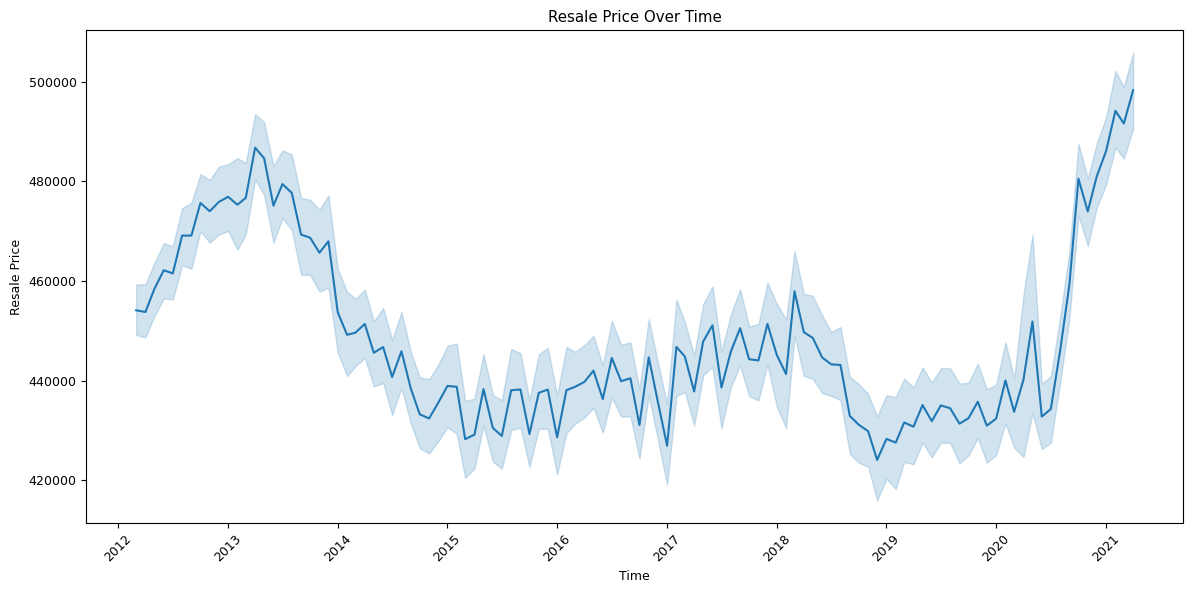

In [70]:
# Sort the DataFrame by the 'time' column
prelim_train_sorted = prelim_train.sort_values(by='tranc_yearmonth')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='tranc_yearmonth', y='resale_price', data=prelim_train_sorted)

plt.xlabel('Time')
plt.ylabel('Resale Price')
plt.title('Resale Price Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Findings:**<br>
We see mean resale prices falling from mid 2013 to 2015. From 2015 to mid 2020, prices remained rather stagnant before drastically increasing in mid 2020.
<br><br>
The fall in resale prices from mid 2013 is likely due to the cooling measures put in place by the government on 12 Jan 2013.There were several measures specific to HDB - Introduction of Mortgage Service Ratio for HDB loans and refinancings, HDB loans lowered from 40% to 35%, and some measures for PRs (PRs that own a HDB flat are now not allowed to sublet their entire flat, PRs that own a HDB must sell it within 6 months of purchasing private property in Singapore). As a whole, these measures serve as deterrants to people considering purchasing a flat, and hence demand fell and resale price fell.
<br><br>
The sharp spike post-2020 could be due to the effects of covid. The shift in COVID-19 lifestyles, characterized by increased remote work, heightened focus on home comfort, and a desire for more space, has significantly impacted the real estate market, leading to a notable surge in resale prices. With more individuals spending extended periods at home, there has been a growing demand for properties with adequate home office spaces, outdoor areas, and flexible living arrangements. This increased demand, coupled with limited housing inventory, has created a competitive market where resale prices spiked.

---
Plot resale price distribution:

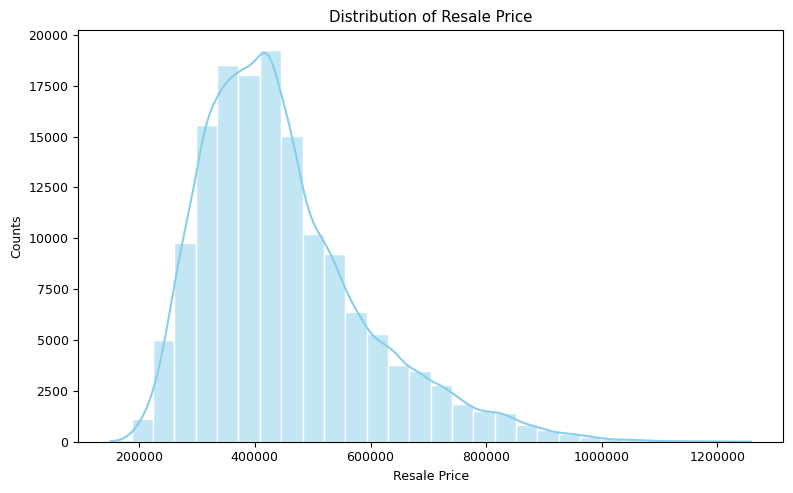

In [64]:
plt.figure(figsize=(8, 5))

sns.histplot(prelim_train['resale_price'], bins=30, kde=True, color='skyblue', edgecolor='white')

plt.ylabel('Counts')
plt.xlabel('Resale Price')
plt.title('Distribution of Resale Price')

# Format x-axis and y-axis tick labels to show full numbers without scientific notation
formatter = mticker.ScalarFormatter(useMathText=False, useOffset=False)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

**Findings:**<br>
The histogram for the distribution of home resale prices shows that the majority of homes are priced on the lower end, with a right-skewed pattern. This indicates that a significant number of homes have lower prices, while relatively fewer homes have higher prices. The median resale price, which is $420,000, represents the middle value in the distribution, separating the dataset into two equal halves. As the histogram skews to the right, it suggests that a few expensive homes contribute to the higher end of the price range, while most homes are priced below the median value.

In [10]:
prelim_train['resale_price'].describe()

count    150634.00
mean     449161.50
std      143307.57
min      150000.00
25%      347000.00
50%      420000.00
75%      520000.00
max     1258000.00
Name: resale_price, dtype: float64

---
## 2.1 Analysing Numerical Features

### 2.1.1 Extracting numerical features

In [11]:
#show all rows
pd.set_option("display.max_rows", None)

#show all dtypes
train.dtypes

id                                    int64
tranc_yearmonth              datetime64[ns]
town                                 object
flat_type                            object
block                                object
street_name                          object
storey_range                         object
floor_area_sqm                      float64
flat_model                           object
lease_commence_date                   int64
resale_price                        float64
tranc_year                            int64
tranc_month                           int64
mid_storey                            int64
lower                                 int64
upper                                 int64
mid                                   int64
full_flat_type                       object
address                              object
floor_area_sqft                     float64
hdb_age                               int64
max_floor_lvl                         int64
year_completed                  

In [12]:
#Extract numerical features
train_num = train.select_dtypes(include=['float64','int64'])
train_num.head()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,latitude,longitude,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,90.00,2006,680000.00,2016,5,11,10,12,11,968.76,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1.31,103.87,1094.09,0.00,0.00,7.00,154.75,1.00,3.00,13.00,84,60,330.08,0,0,1.31,103.87,29.43,1.31,103.87,1138.63,78,1,1.32,103.88,1138.63,224,0,1.32,103.88
1,122598,130.00,1987,665000.00,2012,7,8,7,9,8,1399.32,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,1.35,103.86,866.94,0.00,1.00,3.00,640.15,0.00,1.00,7.00,80,77,903.66,1,1,1.35,103.85,58.21,1.35,103.86,415.61,45,1,1.35,103.85,447.89,232,0,1.35,103.85
2,170897,144.00,1997,838000.00,2013,7,14,13,15,14,1550.02,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1.34,103.76,1459.58,0.00,0.00,4.00,1762.08,0.00,0.00,1.00,84,95,1334.25,1,0,1.35,103.75,214.75,1.34,103.76,498.85,39,0,1.35,103.76,180.07,188,0,1.34,103.76
3,86070,103.00,1992,550000.00,2012,4,3,1,5,3,1108.69,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,1.36,103.85,950.18,0.00,1.00,4.00,726.22,0.00,1.00,9.00,32,86,907.45,1,1,1.35,103.85,43.40,1.36,103.85,389.52,20,1,1.35,103.84,389.52,253,1,1.35,103.84
4,153632,83.00,1987,298000.00,2017,12,2,1,3,2,893.41,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,1.41,103.84,729.77,0.00,1.00,2.00,1540.15,0.00,0.00,1.00,45,0,412.34,0,0,1.42,103.83,129.42,1.42,103.84,401.20,74,0,1.42,103.84,312.03,208,0,1.41,103.84


---
Since 'mid_storey', 'lower', 'upper', 'mid' are essentially telling us the same information of which storey the unit may potentially be located on, we use 'mid_storey' since it gives us the median value of storey_range. And we drop the other columns.

In [13]:
#drop 'lower', 'upper', 'mid' columns
train_num.drop(['lower', 'upper', 'mid'], axis=1, inplace=True)
train_num.head()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,latitude,longitude,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1.31,103.87,1094.09,0.00,0.00,7.00,154.75,1.00,3.00,13.00,84,60,330.08,0,0,1.31,103.87,29.43,1.31,103.87,1138.63,78,1,1.32,103.88,1138.63,224,0,1.32,103.88
1,122598,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,1.35,103.86,866.94,0.00,1.00,3.00,640.15,0.00,1.00,7.00,80,77,903.66,1,1,1.35,103.85,58.21,1.35,103.86,415.61,45,1,1.35,103.85,447.89,232,0,1.35,103.85
2,170897,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1.34,103.76,1459.58,0.00,0.00,4.00,1762.08,0.00,0.00,1.00,84,95,1334.25,1,0,1.35,103.75,214.75,1.34,103.76,498.85,39,0,1.35,103.76,180.07,188,0,1.34,103.76
3,86070,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,1.36,103.85,950.18,0.00,1.00,4.00,726.22,0.00,1.00,9.00,32,86,907.45,1,1,1.35,103.85,43.40,1.36,103.85,389.52,20,1,1.35,103.84,389.52,253,1,1.35,103.84
4,153632,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,1.41,103.84,729.77,0.00,1.00,2.00,1540.15,0.00,0.00,1.00,45,0,412.34,0,0,1.42,103.83,129.42,1.42,103.84,401.20,74,0,1.42,103.84,312.03,208,0,1.41,103.84


---
#### Preliminary Correlation analysis

Plot correlation heatmap for numeric values:

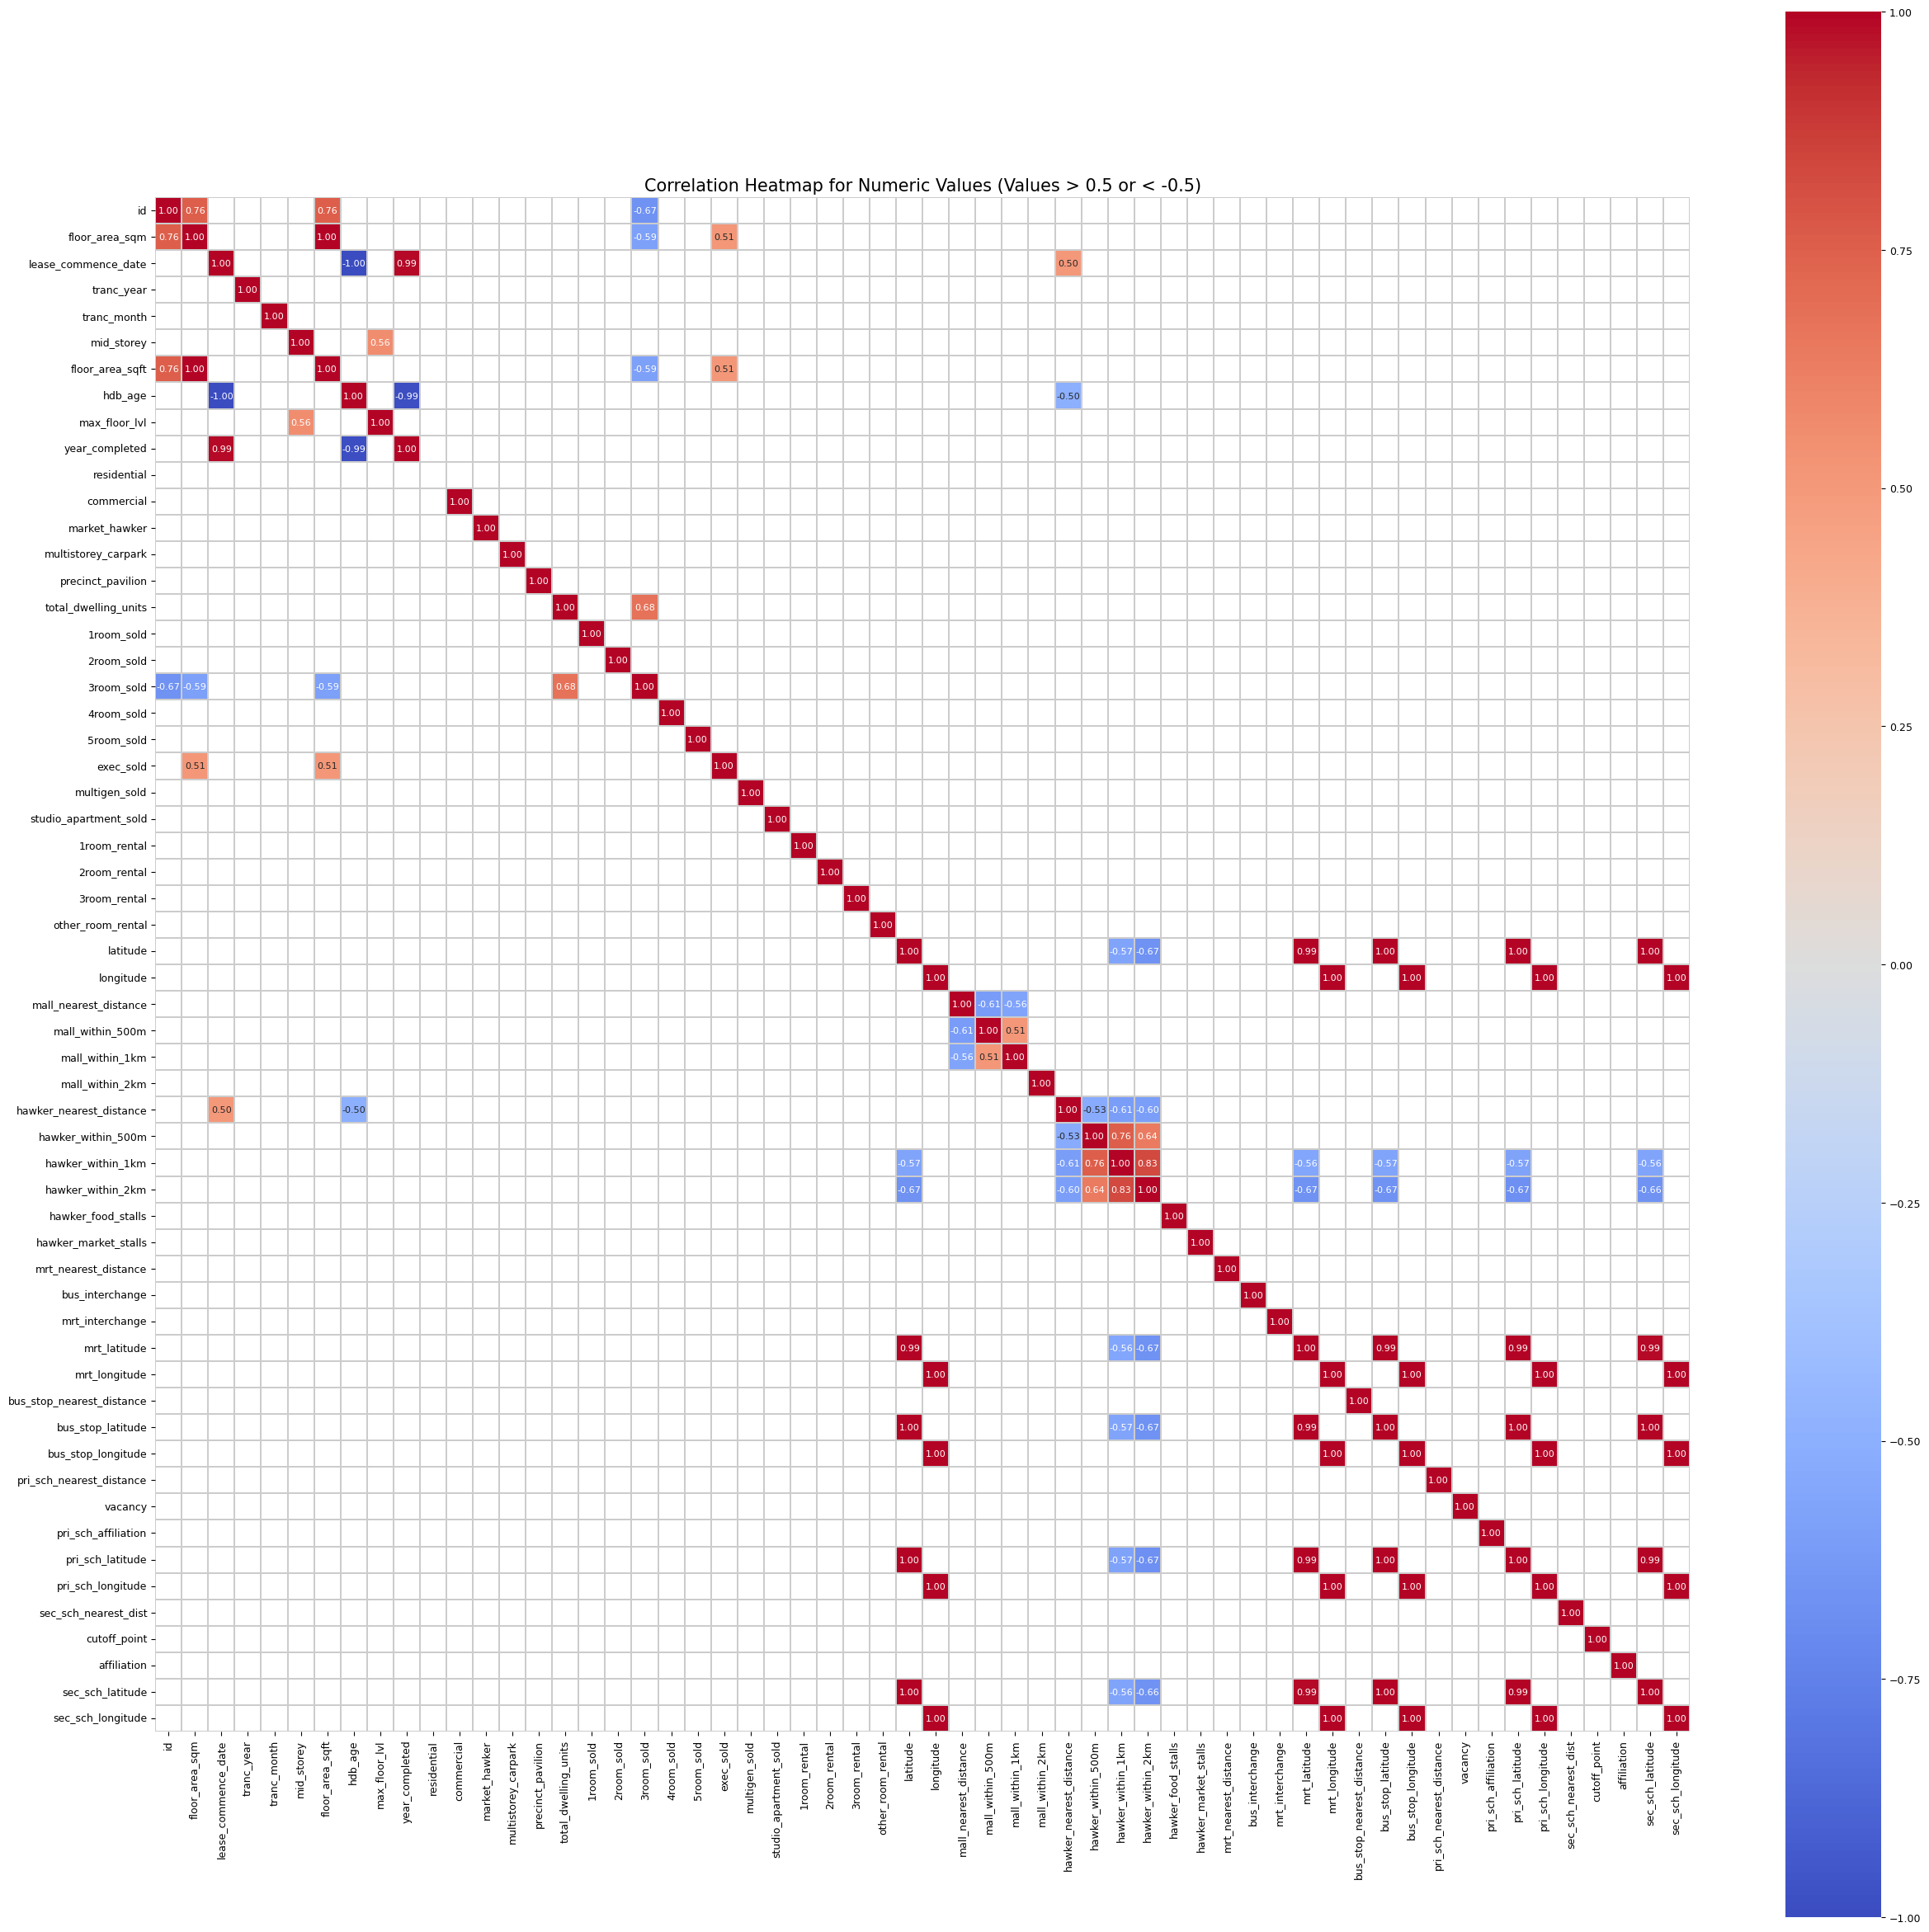

In [14]:
# Set the overall font size for the plot
plt.rc('font', size=9)

# Calculate the correlation matrix
correlation_matrix = train_num.drop(columns='resale_price').corr()

# Create a boolean mask to show values greater than 0.5 or smaller than -0.5
mask = (correlation_matrix <= 0.5) & (correlation_matrix >= -0.5)

# Create the heatmap with the updated mask
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, square=True, mask=mask,
            cmap='coolwarm', fmt=".2f", linewidths=0.01, linecolor='#CCCCCC')
plt.title('Correlation Heatmap for Numeric Values (Values > 0.5 or < -0.5)', fontsize=15)
plt.show()

---
**Preliminary findings:**<br>
It is hard to deduce much from the above correlation heatmap, because there are too many categorical columns that are correlated, i.e. describing same features. These information should be feature engineered and summarised so we can drop more columns. Hopefully we can get clearer findings thereafter.

**Some ideas for further cleanup / feature engineering:**<br>
**1. Drop all latitude and longitude values**<br>
   This is because latitude and longitude will only be useful if we do further geographical analysis. For now, this information is already captured in the distance from amenities to property (e.g. columns like bus_stop_nearest_distance, pri_sch_nearest_dist, etc)
   
**2. Summarise no of malls and no of hawkers within proximity of 2km**<br>
    This is because the "mall_within_500m" and	"mall_within_1km" actually fall within "mall_within_2km". <br>We can hence summarise these 3 features as one. Likewise for no of hawkers.

**3. Drop columns which would not contribute to resale price**<br>
Some examples are:
* ID - This is a unique identifier for each property and hence it would not have any predictive power.
* Residential - We are looking at housing property, all rows are positive (1) for residential.
   
**4. Create Price per sqft (psf) feature**

---
### 2.1.2 Further Cleanup

1. Drop all latitude and longitude values:

In [15]:
train_num.drop(['latitude', 'longitude', 'mrt_latitude', 'mrt_longitude', 'bus_stop_latitude', 'bus_stop_longitude', 'pri_sch_latitude', 
                'pri_sch_longitude', 'sec_sch_latitude','sec_sch_longitude'], axis=1, inplace=True)
train_num.head()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1094.09,0.00,0.00,7.00,154.75,1.00,3.00,13.00,84,60,330.08,0,0,29.43,1138.63,78,1,1138.63,224,0
1,122598,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,866.94,0.00,1.00,3.00,640.15,0.00,1.00,7.00,80,77,903.66,1,1,58.21,415.61,45,1,447.89,232,0
2,170897,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1459.58,0.00,0.00,4.00,1762.08,0.00,0.00,1.00,84,95,1334.25,1,0,214.75,498.85,39,0,180.07,188,0
3,86070,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,950.18,0.00,1.00,4.00,726.22,0.00,1.00,9.00,32,86,907.45,1,1,43.40,389.52,20,1,389.52,253,1
4,153632,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,729.77,0.00,1.00,2.00,1540.15,0.00,0.00,1.00,45,0,412.34,0,0,129.42,401.20,74,0,312.03,208,0


---
2. Summarise no of malls and no of hawkers within proximity of 2km

In [16]:
#combine mall and hawker columns
train_num.drop(['mall_within_500m', 'mall_within_1km'], axis=1, inplace=True)

#combine hawker columns
train_num.drop(['hawker_within_500m', 'hawker_within_1km'], axis=1, inplace=True)
train_num.head()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,0,0,29.43,1138.63,78,1,1138.63,224,0
1,122598,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,1,1,58.21,415.61,45,1,447.89,232,0
2,170897,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,1,0,214.75,498.85,39,0,180.07,188,0
3,86070,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,1,1,43.40,389.52,20,1,389.52,253,1
4,153632,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,0,0,129.42,401.20,74,0,312.03,208,0


3. Drop columns which would not contribute to resale price:<br>
* ID
* Residential (Since all rows are residential, we are looking at housing property!)

In [17]:
#drop residential column because all rows are residential
train_num.drop(['id', 'residential'], axis=1, inplace=True)
print(train.shape)
train_num.head()

(150634, 77)


,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,0,0,29.43,1138.63,78,1,1138.63,224,0
1,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,1,1,58.21,415.61,45,1,447.89,232,0
2,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,1,0,214.75,498.85,39,0,180.07,188,0
3,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,1,1,43.40,389.52,20,1,389.52,253,1
4,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,0,0,129.42,401.20,74,0,312.03,208,0


---
### 2.1.3 Feature Engineering / Analysis

#### Create price per sqft (psf) feature

In [18]:
train_num['psf']= train_num['resale_price']/train_num['floor_area_sqft']

In [19]:
train_num.head()

,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation,psf
0,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,0,0,29.43,1138.63,78,1,1138.63,224,0,701.93
1,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,1,1,58.21,415.61,45,1,447.89,232,0,475.23
2,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,1,0,214.75,498.85,39,0,180.07,188,0,540.64
3,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,1,1,43.40,389.52,20,1,389.52,253,1,496.08
4,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,0,0,129.42,401.20,74,0,312.03,208,0,333.55


[701.92823816 645.15463066 761.0079303  ... 691.82539118 716.54322623
 647.26989175]


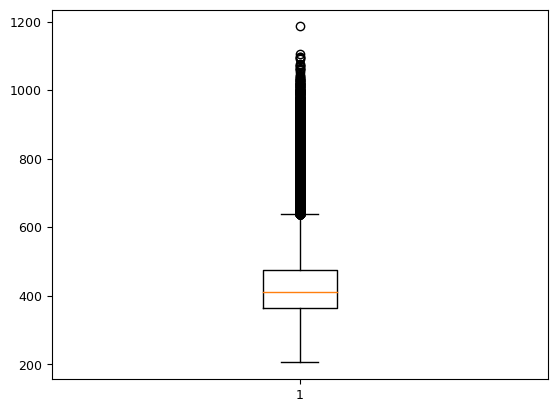

In [20]:
#use boxplot to examine for outliers

boxplot = plt.boxplot(train_num['psf'], vert=True)

# Get the outliers
outliers = [flier.get_ydata() for flier in boxplot['fliers']]

# Print the values of outliers
for outlier in outliers:
    print(outlier)

Boxplot shows many outliers, let's verify if this is true.

In [21]:
train_num[['psf']].describe()

,psf
count,150634.00
mean,434.13
std,104.80
min,205.11
25%,364.97
50%,412.00
75%,474.06
max,1185.64


Compared to housing prices today, where HDB resale prices go up as high as $1200 psf, the values described seem acceptable. Hence, it is decided we keep these outlier values.

---

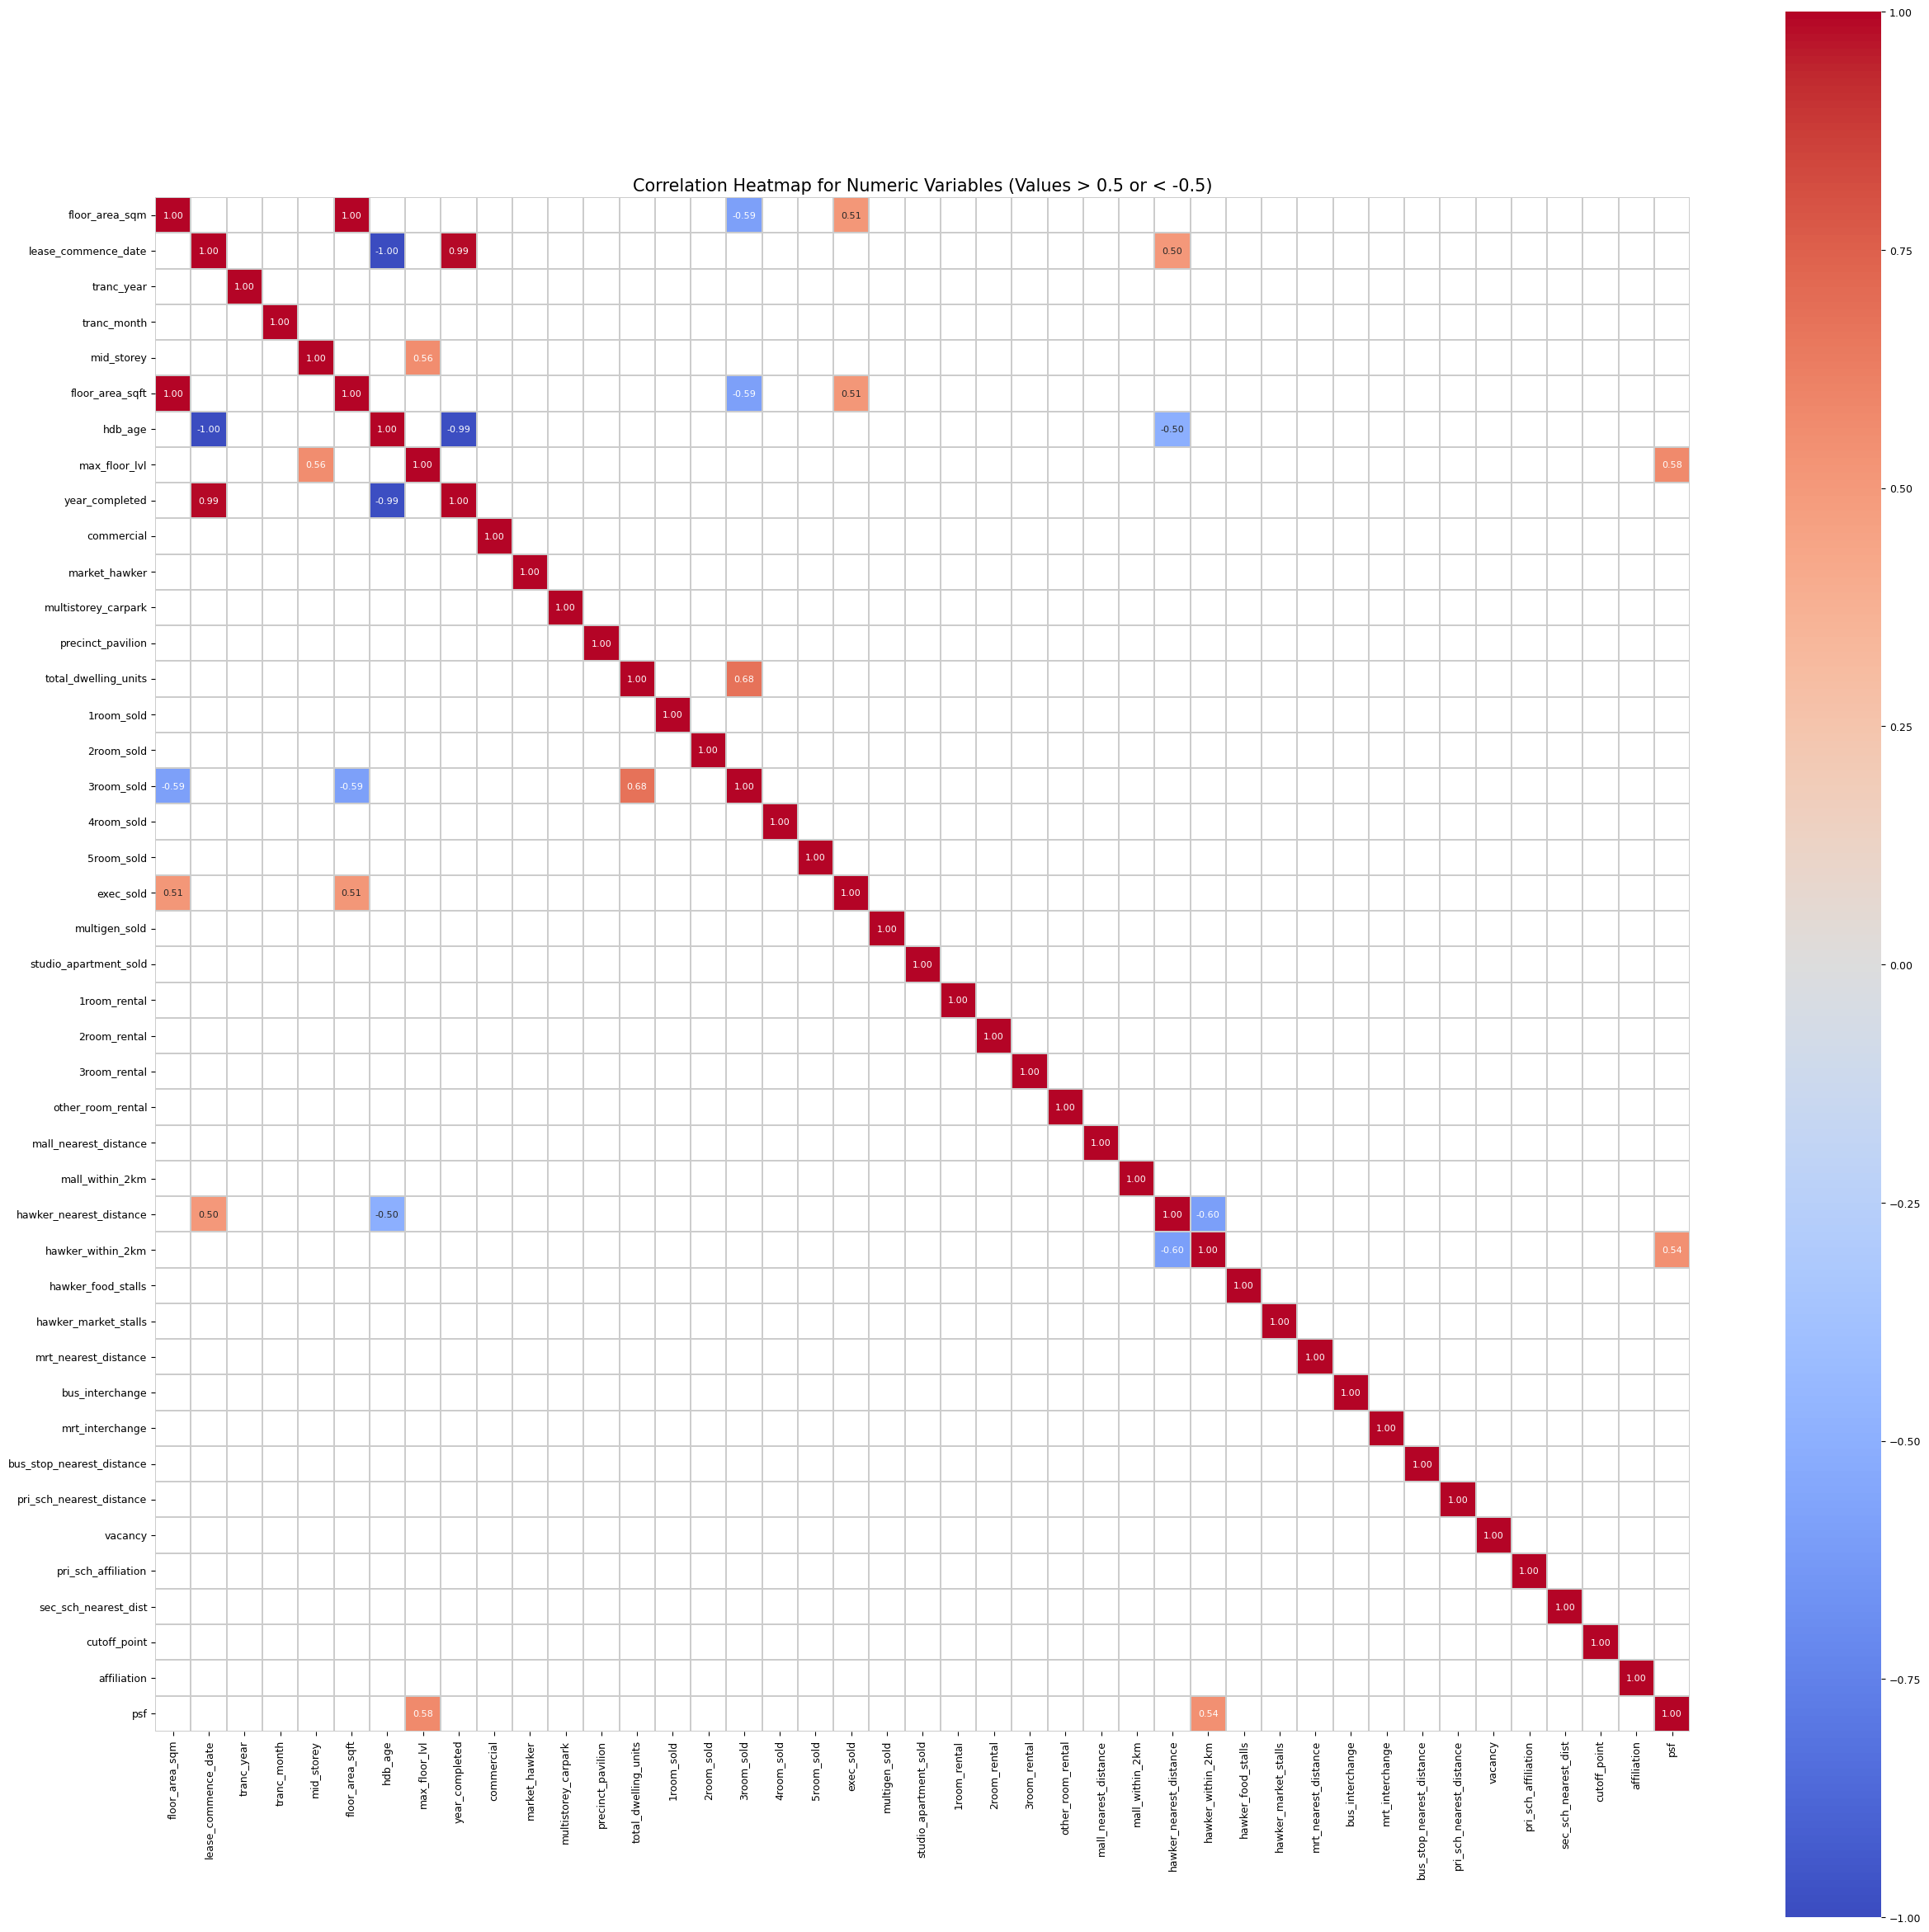

In [22]:
# Set the overall font size for the plot
plt.rc('font', size=9)

# Calculate the correlation matrix
correlation_matrix = train_num.drop(columns='resale_price').corr()

# Create a boolean mask to show values greater than 0.5 or smaller than -0.5
mask = (correlation_matrix <= 0.5) & (correlation_matrix >= -0.5)

# Create the heatmap with the updated mask
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, square=True, mask=mask,
            cmap='coolwarm', fmt=".2f", linewidths=0.01, linecolor='#CCCCCC')
plt.title('Correlation Heatmap for Numeric Variables (Values > 0.5 or < -0.5)', fontsize=15)
plt.show()

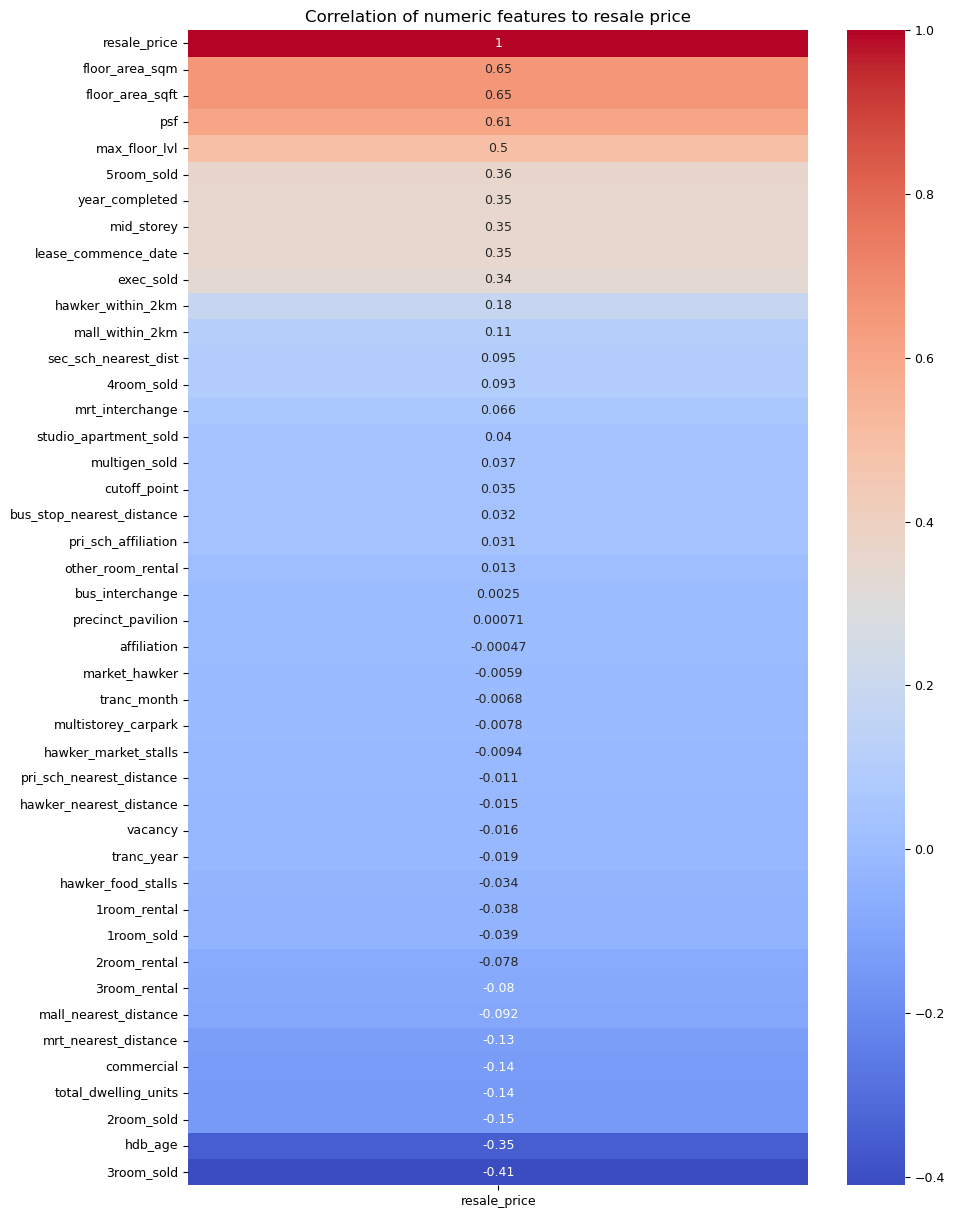

In [23]:
plt.figure(figsize=(10, 15))
# Plotting the heatmap with respect to the correlation of the features with the target variable 'resale_price'
heatmap = sns.heatmap(train_num.corr()[['resale_price']].sort_values(by='resale_price', ascending=False), annot=True, cmap='coolwarm')

plt.title('Correlation of numeric features to resale price', fontsize=12)
plt.show()

In [24]:
train_num.corr()[['resale_price']].sort_values(by='resale_price', ascending=False)

,resale_price
resale_price,1.00
floor_area_sqm,0.65
floor_area_sqft,0.65
psf,0.61
max_floor_lvl,0.50
5room_sold,0.36
year_completed,0.35
mid_storey,0.35
lease_commence_date,0.35
exec_sold,0.34


---
#### Findings - Correlation between numerical features and resale price
* According to the **correlation heatmap between numerical features**:<br>
  Features with strong correlation to each other are:
  * 'floor_area_sqm' to 'floor_area_sqft' 
  * 'year_completed' to 'hdb_age' and 'lease_commence_date'
  * 'max_floor_lvl' to 'mid_storey'
  * '3room_sold' to 'floor_area_sqm', 'floor_area_sqft' and 'total_dwelling_units'
  * 'exec_sold' to 'floor_area_sqm', 'floor_area_sqft'
  * 'hawker_nearest_distance' to 'hdb_age' and 'lease_commence_date'
  * 'hawker_within_2km' to 'hawker_nearest_distance'
  * 'psf' to 'max_floor_lvl' and 'hawker_within_2km'

<br>

* According to the **correlation between numerical features to resale price**:
    * **Strong correlation to resale prices:** 'floor_area_sqm', 'floor_area_sqft', 'psf', 'max_floor_lvl' (positive correlation > 0.5)
    * **Weak correlation to resale prices:** 5room_sold, year_completed, mid_story, lease_commenced, exec_sold, (positive correlation > 0.3 but < 0.5) and hdb_age, 3_room_sold (negative correlation < -0.3 but > -0.5) 
    * **Weaker correlation to resale prices:** hawker_within_2km, mall_within_2km (positive correlation > 0.1 but < 0.3) and mrt_nearest_distance, commercial, total_dwelling_units, 2room_sold (negative correlation < -0.1 but > -0.3) 

---
Upon first plot of train_num, I realised some of the numerical ordinal columns (binarized) would not reflect accurately in the correlation heatmap, so let's extract these columns from train_num for separate analysis:

In [25]:
#extract new dataframe for binarized features
binarized_train_num = train_num[['psf', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
                       'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation']]

In [26]:
#drop binarized features from numerical train_num dataset
train_num.drop(['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
                       'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation'], axis=1, inplace=True)

In [191]:
train_num.columns

Index(['floor_area_sqm', 'resale_price', 'tranc_year', 'tranc_month',
       'mid_storey', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'studio_apartment_sold', '2room_rental',
       'mall_nearest_distance', 'mall_within_2km', 'hawker_nearest_distance',
       'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'sec_sch_nearest_dist',
       'cutoff_point'],
      dtype='object')

---
#### Histogram for numeric columns

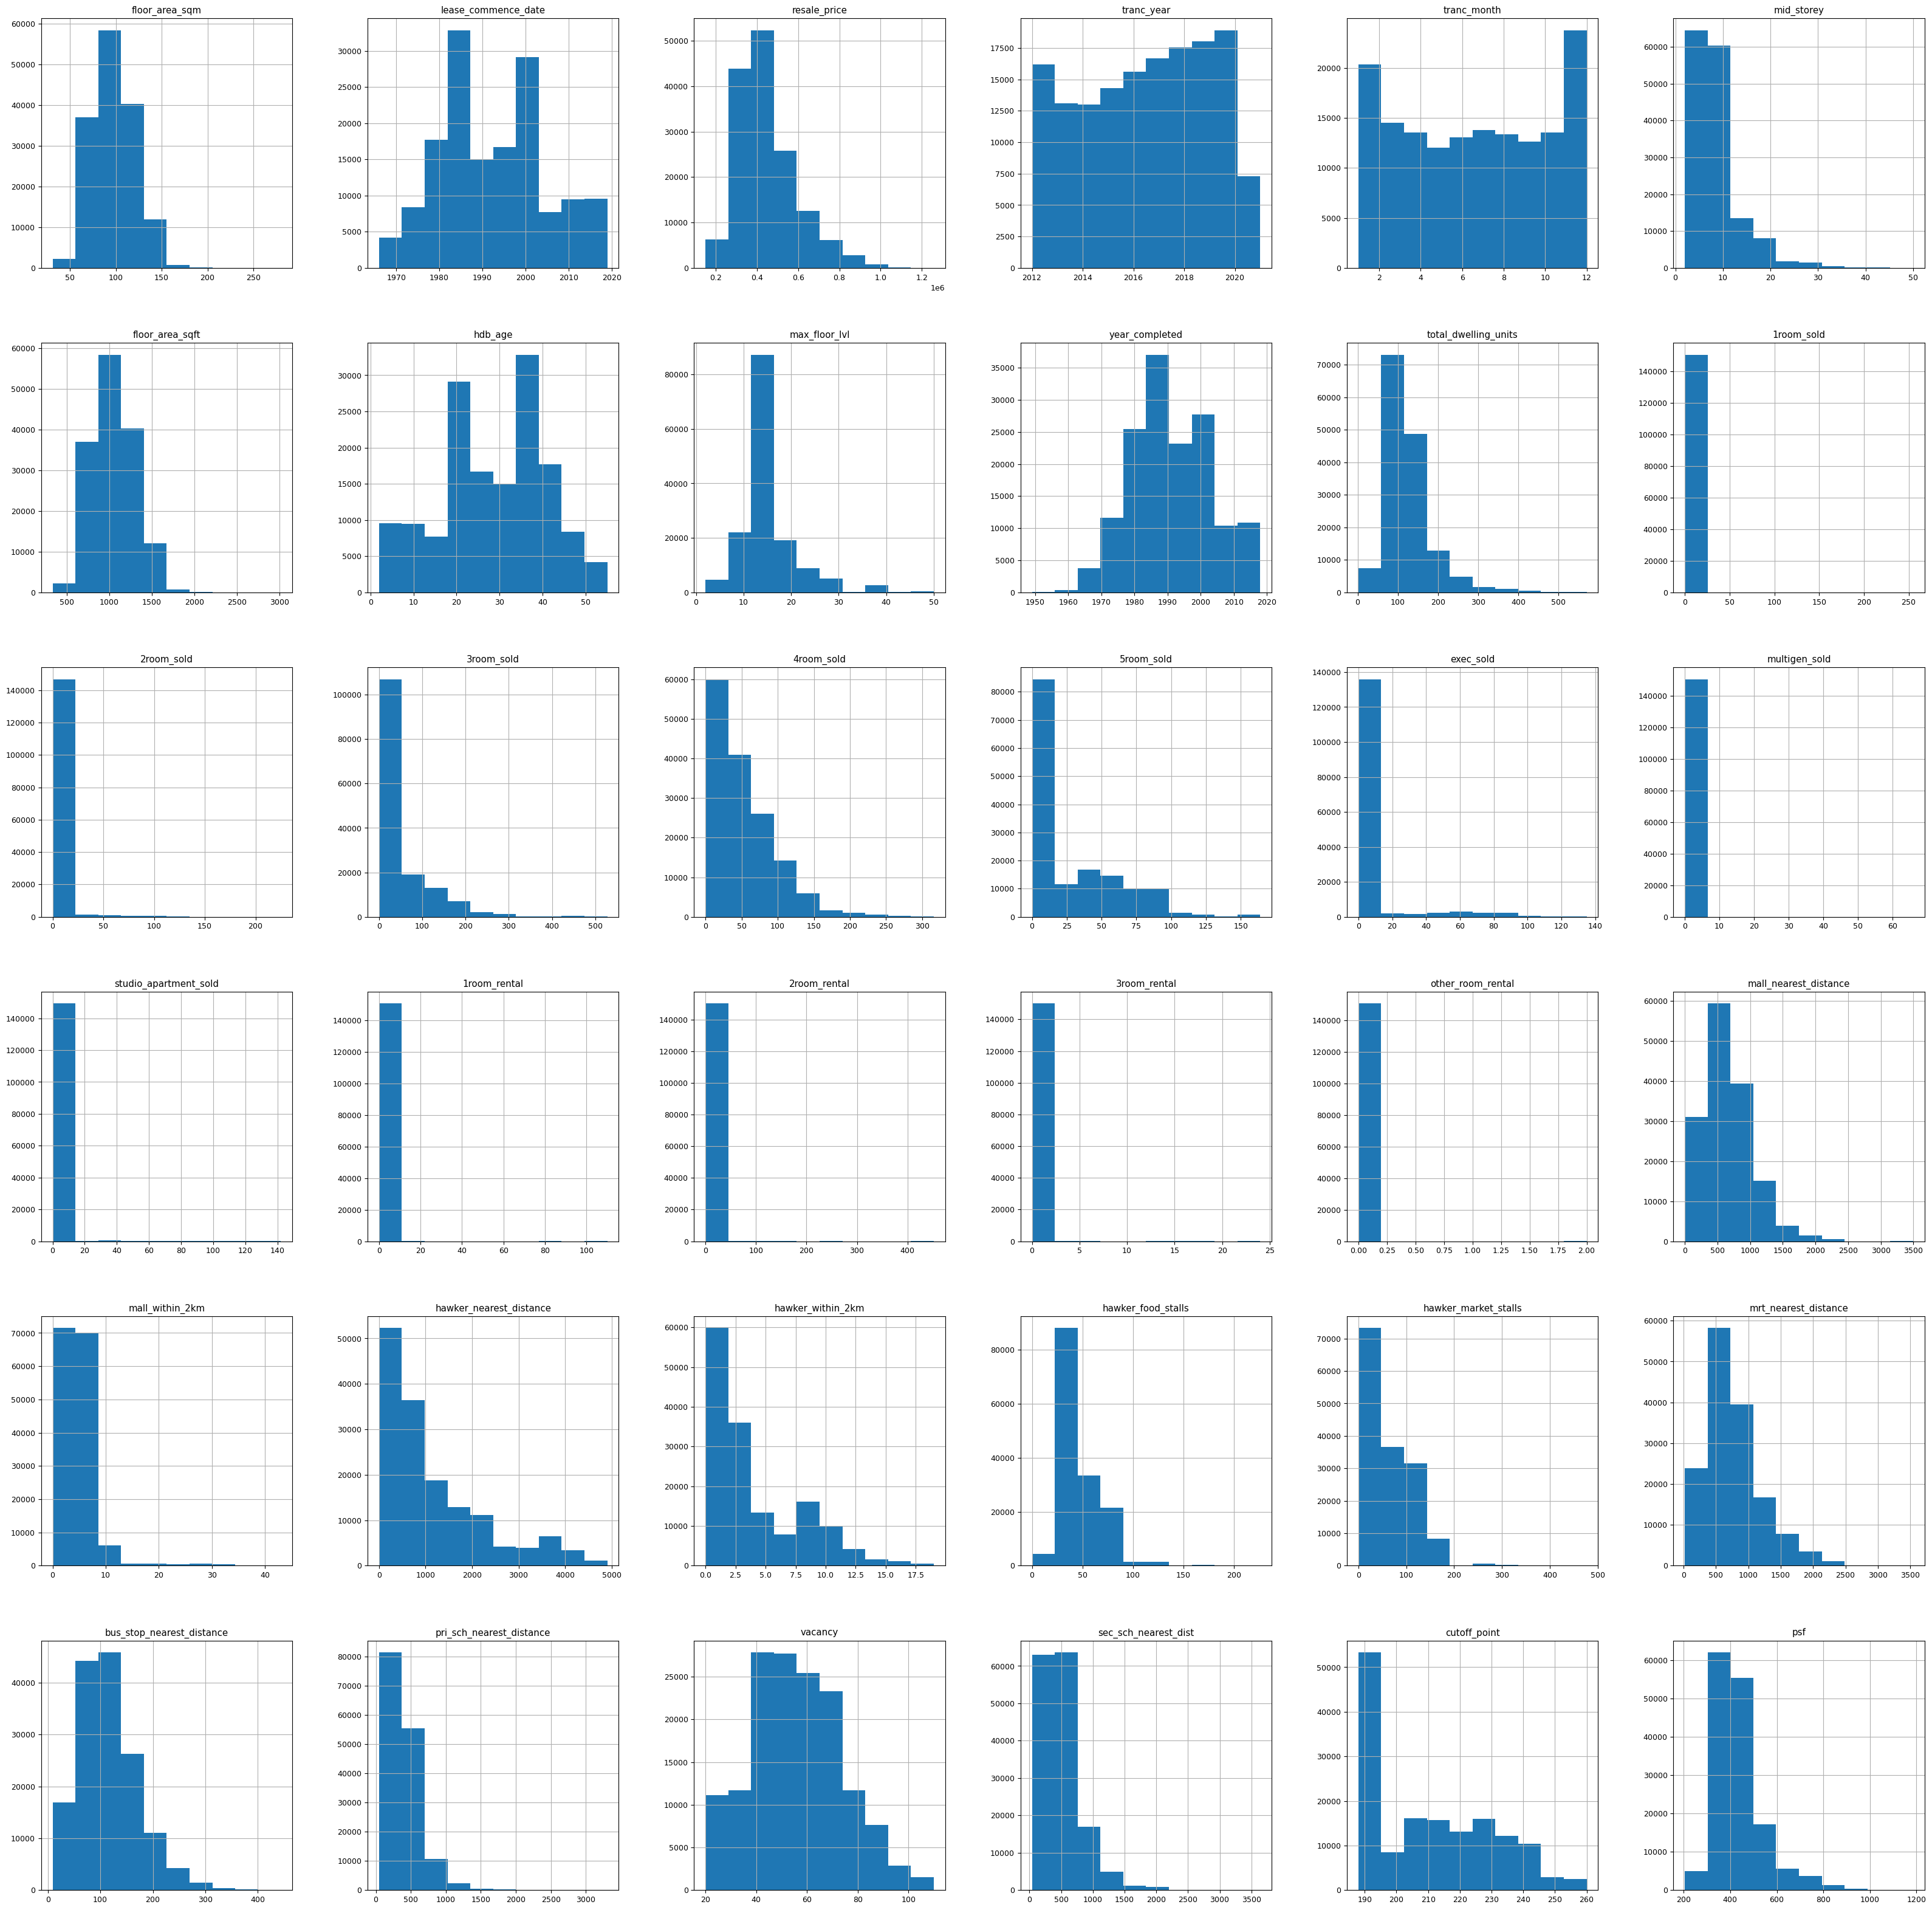

In [28]:
train_num.hist(figsize=(40, 40));

**General Findings:**

1. Normality of distributions<br>
    From the above histogram, we can tell that some of the features are not normally distributed. This would be addressed and improved, when working with the hyperparameters of ridge and lasso.

2. Outliers<br>
   Outliers are evident in the histograms, however, as too many features have outliers, and in total there are a large proportion of outliers, we will keep the outliers for now and do a blanket correction later when scaling for ridge and lasso regression.
   
**Other Findings on the features:**
1. **Tranc_year:<br>** While we know resale prices spiked in 2020, the volume of resale transactions actually fell in 2020. This is probably due to the circuit breaker lockdown period that we faced in 2020 at the peak of Covid.
2. **Tranc_month:<br>** Interesting how January and December had the most volume of transactions. This is probably due to people receiving bonuses during this period and having greater confidence to spend their money on a new house. Further exploration could be done to see if the months of higher number of transactions this is aligned with resale price - so I can help property owners know which is the best period to target to sell their house.
3. **For mall, hawker, mrt, busstop, school nearest distance:<br>** It is good seeing most homes had these amenities within 500m of their house. The government's plans to make each town self-sufficient seems successful. Also, this would be good for most home owners to market their house. However, once most properties have amenities in close proximity, then it becomes a minimum standard for all properties. Other factors such as number of malls or hawkers within 500m would then be a more valuable feature to consider, since the property would give the owner more variety of choices for recreation or food.


---
#### Check for features with too few value counts, and would have no predictive impact:

In [29]:
#List features with suspicious looking histograms
check_value = ['1room_sold', '2room_sold', '3room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
               'other_room_rental']

In [30]:
for i in check_value:
    print(train_num[[i]].sum()/len(train_num))

1room_sold   0.14
dtype: float64
2room_sold   1.78
dtype: float64
3room_sold   39.22
dtype: float64
exec_sold   5.94
dtype: float64
multigen_sold   0.02
dtype: float64
studio_apartment_sold   0.45
dtype: float64
1room_rental   0.06
dtype: float64
2room_rental   0.62
dtype: float64
3room_rental   0.06
dtype: float64
other_room_rental   0.00
dtype: float64


Let's drop features that are < 5% of total number of rows:

In [31]:
train_num.drop(['multigen_sold', '1room_rental', '3room_rental', 'other_room_rental'], axis=1, inplace=True)

In [32]:
train_num.head()

,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,studio_apartment_sold,2room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,sec_sch_nearest_dist,cutoff_point,psf
0,90.00,2006,680000.00,2016,5,11,968.76,15,25,2005,142,0,0,0,96,46,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,29.43,1138.63,78,1138.63,224,701.93
1,130.00,1987,665000.00,2012,7,8,1399.32,34,9,1987,112,0,0,0,56,56,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,58.21,415.61,45,447.89,232,475.23
2,144.00,1997,838000.00,2013,7,14,1550.02,24,16,1996,90,0,0,0,0,30,60,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,214.75,498.85,39,180.07,188,540.64
3,103.00,1992,550000.00,2012,4,3,1108.69,29,11,1990,75,0,0,0,68,7,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,43.40,389.52,20,389.52,253,496.08
4,83.00,1987,298000.00,2017,12,2,893.41,34,4,1987,48,0,0,0,30,18,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,129.42,401.20,74,312.03,208,333.55


---
#### Final Numerical features selected

Considering the earlier correlation heatmaps between numerical features, we drop highly correlated features (correlation >0.9)
<br><br>
Drop Correlated numerical features:
* floor_area_sqm' to 'floor_area_sqft' - drop floor_area_sqft
* 'year_completed' to 'hdb_age' and 'lease_commence_date'  - drop 'year_completed' and 'lease_commence_date'

In [33]:
train_num.drop(['floor_area_sqft', 'year_completed', 'lease_commence_date', 'psf'], axis=1, inplace=True)
train_num.head(10)

,floor_area_sqm,resale_price,tranc_year,tranc_month,mid_storey,hdb_age,max_floor_lvl,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,studio_apartment_sold,2room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,sec_sch_nearest_dist,cutoff_point
0,90.00,680000.00,2016,5,11,15,25,142,0,0,0,96,46,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,29.43,1138.63,78,1138.63,224
1,130.00,665000.00,2012,7,8,34,9,112,0,0,0,56,56,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,58.21,415.61,45,447.89,232
2,144.00,838000.00,2013,7,14,24,16,90,0,0,0,0,30,60,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,214.75,498.85,39,180.07,188
3,103.00,550000.00,2012,4,3,29,11,75,0,0,0,68,7,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,43.40,389.52,20,389.52,253
4,83.00,298000.00,2017,12,2,34,4,48,0,0,0,30,18,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,129.42,401.20,74,312.03,208
5,65.00,335000.00,2013,1,8,46,12,193,0,0,188,0,5,0,0,0,684.00,6.00,148.42,11.00,79,82,678.29,229.68,594.13,65,608.84,224
6,120.00,433000.00,2018,5,8,34,17,64,0,0,0,0,64,0,0,0,490.26,8.00,516.98,4.00,40,0,1370.65,46.57,331.67,48,294.83,224
7,68.00,340000.00,2012,3,8,41,12,132,0,0,110,22,0,0,0,0,1749.15,3.00,734.25,5.00,36,75,291.63,71.97,365.79,56,835.01,188
8,125.00,700000.00,2020,1,11,32,25,92,0,0,0,0,84,8,0,0,445.72,1.00,1032.85,4.00,31,51,1584.10,105.18,398.37,30,866.36,208
9,110.00,490000.00,2014,6,11,20,17,96,0,0,0,32,64,0,0,0,853.38,7.00,1743.70,1.00,40,0,1055.00,89.35,94.34,75,458.53,243


In [34]:
train_num.shape

(150634, 28)

---
#### Numerical Ordinal features
Realised some of the numerical ordinal columns would not reflect well in the correlation heatmap, so let's extract these columns for further analysis, by doing pair plots:

In [35]:
binarized_train_num.head()

,psf,commercial,market_hawker,multistorey_carpark,precinct_pavilion,bus_interchange,mrt_interchange,pri_sch_affiliation,affiliation
0,701.93,0,0,0,0,0,0,1,0
1,475.23,0,0,0,0,1,1,1,0
2,540.64,0,0,0,0,1,0,0,0
3,496.08,1,0,0,0,1,1,1,1
4,333.55,0,0,0,0,0,0,0,0


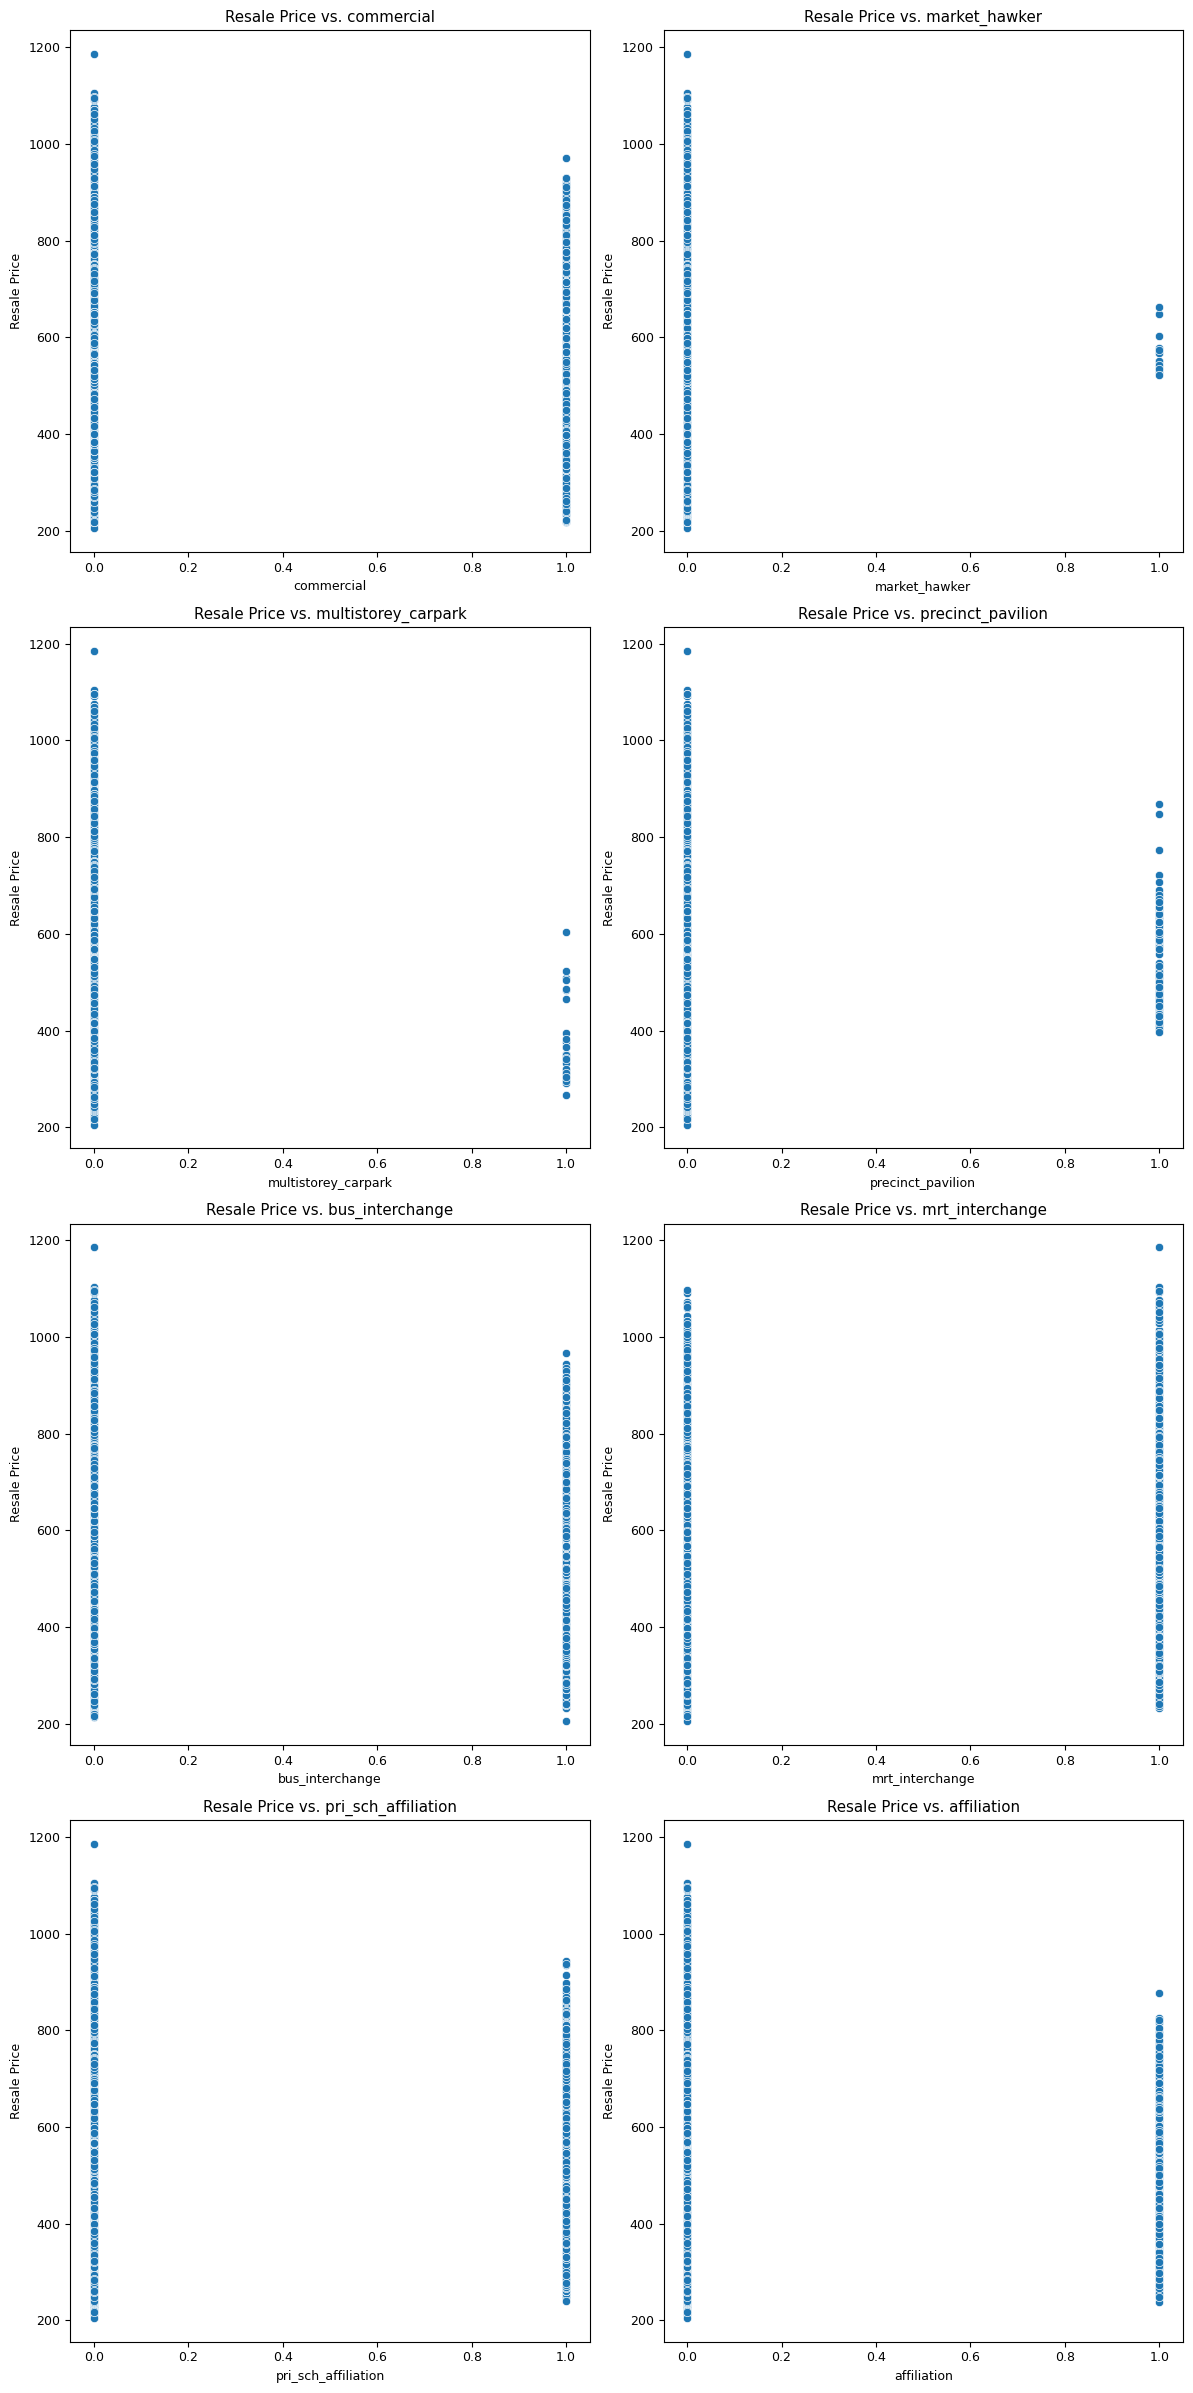

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'binary_data' with binary columns and 'resale_price' column

# List of binary column names
binary_columns = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
                  'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation']

# Calculate the number of rows needed for the subplots
num_rows = (len(binary_columns) + 1) // 2

# Create a subplot with 2 columns for each binary column
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

# Flatten the 2D axes array to a 1D array to iterate through binary columns
axes = axes.flatten()

# Create scatter plots for each binary column against the resale price
for i, column in enumerate(binary_columns):
    sns.scatterplot(x=column, y='psf', data=binarized_train_num, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Resale Price')
    axes[i].set_title(f'Resale Price vs. {column}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Findings - Ordinal Features:**<br>
From the above scatter plots, it seems like as individual features, none of the features are critical enough for us to observe a trend. Perhaps for the first preliminary model, we will plot these features as encoded variables to observe influence on the model.

In [37]:
#Final numerical ordinal features selected
binarized_train_num = binarized_train_num.drop(columns='psf')
binarized_train_num.head()

,commercial,market_hawker,multistorey_carpark,precinct_pavilion,bus_interchange,mrt_interchange,pri_sch_affiliation,affiliation
0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,1,1,0
2,0,0,0,0,1,0,0,0
3,1,0,0,0,1,1,1,1
4,0,0,0,0,0,0,0,0


In [38]:
binarized_train_num.shape

(150634, 8)

---
## 2.2 Analysing Categorical Features

### 2.2.1 Extracting categorical features

In [39]:
#Extract categorical features
train_cat = train.select_dtypes(include=['object'])

# Include 'resale_price' column in train_cat
train_cat = pd.concat([train_cat, train['resale_price']], axis=1)

print(train_cat.shape)
train_cat.head()

(150634, 15)


,town,flat_type,block,street_name,storey_range,flat_model,full_flat_type,address,postal,planning_area,mrt_name,bus_stop_name,pri_sch_name,sec_sch_name,resale_price
0,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,Model A,4 ROOM Model A,"3B, UPP BOON KENG RD",382003,Kallang,Kallang,Blk 3B,Geylang Methodist School,Geylang Methodist School,680000.00
1,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,Improved,5 ROOM Improved,"153, BISHAN ST 13",570153,Bishan,Bishan,BLK 151A MKT,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,665000.00
2,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,Apartment,EXECUTIVE Apartment,"289B, BT BATOK ST 25",651289,Bukit Batok,Bukit Batok,Blk 289E,Keming Primary School,Yusof Ishak Secondary School,838000.00
3,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,Model A,4 ROOM Model A,"232, BISHAN ST 22",570232,Bishan,Bishan,Opp Bishan Nth Shop Mall,Catholic High School,Catholic High School,550000.00
4,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,Simplified,4 ROOM Simplified,"876, YISHUN ST 81",760876,Yishun,Khatib,Blk 873,Naval Base Primary School,Orchid Park Secondary School,298000.00


In [40]:
train_cat.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'full_flat_type', 'address', 'postal', 'planning_area',
       'mrt_name', 'bus_stop_name', 'pri_sch_name', 'sec_sch_name',
       'resale_price'],
      dtype='object')

---
### 2.2.2 Feature Engineering / Analysis
#### Town, Planning area and mrt_name
Town, Planning area and mrt_name seem to somewhat provide information on geographic location of the property. Let's have a further look into these 3 columns:

In [41]:
print(f"TOWN:{train_cat['town'].unique()}")
print(f"TOWN:{train_cat['town'].nunique()}")

print(f"PLANNING AREA:{train_cat['planning_area'].unique()}")
print(f"PLANNING AREA:{train_cat['planning_area'].nunique()}")

print(f"MRT NAME:{train_cat['mrt_name'].unique()}")
print(f"MRT NAME:{train_cat['mrt_name'].nunique()}")

TOWN:['KALLANG/WHAMPOA' 'BISHAN' 'BUKIT BATOK' 'YISHUN' 'GEYLANG' 'HOUGANG'
 'BEDOK' 'SENGKANG' 'TAMPINES' 'SERANGOON' 'BUKIT MERAH' 'BUKIT PANJANG'
 'WOODLANDS' 'JURONG WEST' 'TOA PAYOH' 'CHOA CHU KANG' 'SEMBAWANG'
 'ANG MO KIO' 'PASIR RIS' 'CLEMENTI' 'PUNGGOL' 'JURONG EAST'
 'CENTRAL AREA' 'QUEENSTOWN' 'BUKIT TIMAH' 'MARINE PARADE']
TOWN:26
PLANNING AREA:['Kallang' 'Bishan' 'Bukit Batok' 'Yishun' 'Geylang' 'Hougang' 'Bedok'
 'Sengkang' 'Tampines' 'Serangoon' 'Bukit Merah' 'Bukit Panjang'
 'Woodlands' 'Jurong West' 'Toa Payoh' 'Choa Chu Kang' 'Sembawang'
 'Novena' 'Ang Mo Kio' 'Pasir Ris' 'Clementi' 'Punggol' 'Jurong East'
 'Rochor' 'Queenstown' 'Bukit Timah' 'Outram' 'Tanglin' 'Marine Parade'
 'Western Water Catchment' 'Downtown Core' 'Changi']
PLANNING AREA:32
MRT NAME:['Kallang' 'Bishan' 'Bukit Batok' 'Khatib' 'MacPherson' 'Kovan'
 'Bedok North' 'Marymount' 'Sengkang' 'Buangkok' 'Tampines' 'Tiong Bahru'
 'Bukit Panjang' 'Marsiling' 'Woodlands South' 'Admiralty' 'Pioneer'
 'Braddell

From the above, we see the unique value counts of the 3 features:
* TOWN: 26
* PLANNING AREA: 32
* MRT NAME: 94

For the preliminary model, it was decided that all 3 features are to be kept first. This is because all 3 features convey nuanced information that could still have some separate predictive potential. Towns are governed by HDB, where each town is designed to be self-sufficient, so "towns" could encompass information about the shops, schools, social and recreational facilities, and greenery. Planning area on the other hand, is part of masterplanning, governed by URA.

MRT name is to be kept as it would provide additional information on accessibility.

---

In [42]:
planning_area_count = train_cat['planning_area'].value_counts()
planning_area_count

Jurong West                11451
Woodlands                  11334
Sengkang                   11069
Tampines                   10506
Yishun                     10042
Bedok                       9062
Punggol                     7793
Hougang                     7557
Ang Mo Kio                  6908
Choa Chu Kang               6328
Bukit Merah                 5854
Bukit Batok                 5700
Bukit Panjang               5686
Toa Payoh                   4817
Pasir Ris                   4725
Queenstown                  4103
Geylang                     3986
Sembawang                   3723
Clementi                    3633
Jurong East                 3470
Kallang                     3163
Serangoon                   3121
Bishan                      2871
Novena                      1091
Marine Parade                943
Outram                       759
Rochor                       468
Bukit Timah                  362
Changi                        38
Downtown Core                 31
Tanglin   

For planning areas whose value counts fall below 1000, let's combine them to form a value called "planning_area_others".

In [43]:
#extract planning areas whose counts <1000
planning_area_below_1000 = planning_area_count[planning_area_count<1000]
planning_area_below_1000

Marine Parade              943
Outram                     759
Rochor                     468
Bukit Timah                362
Changi                      38
Downtown Core               31
Tanglin                     25
Western Water Catchment     15
Name: planning_area, dtype: int64

In [44]:
#Check total no of unique values before grouping planning areas < 1000 count
len(train_cat['planning_area'].unique())

32

In [45]:
# Converting planning areas <1000 to be planning_area_others
train_cat['planning_area'] = train_cat['planning_area'].apply(lambda x: 'planning_area_others' if x in planning_area_below_1000 else x)

In [46]:
#check total no of unique values again
len(train_cat['planning_area'].unique())

25

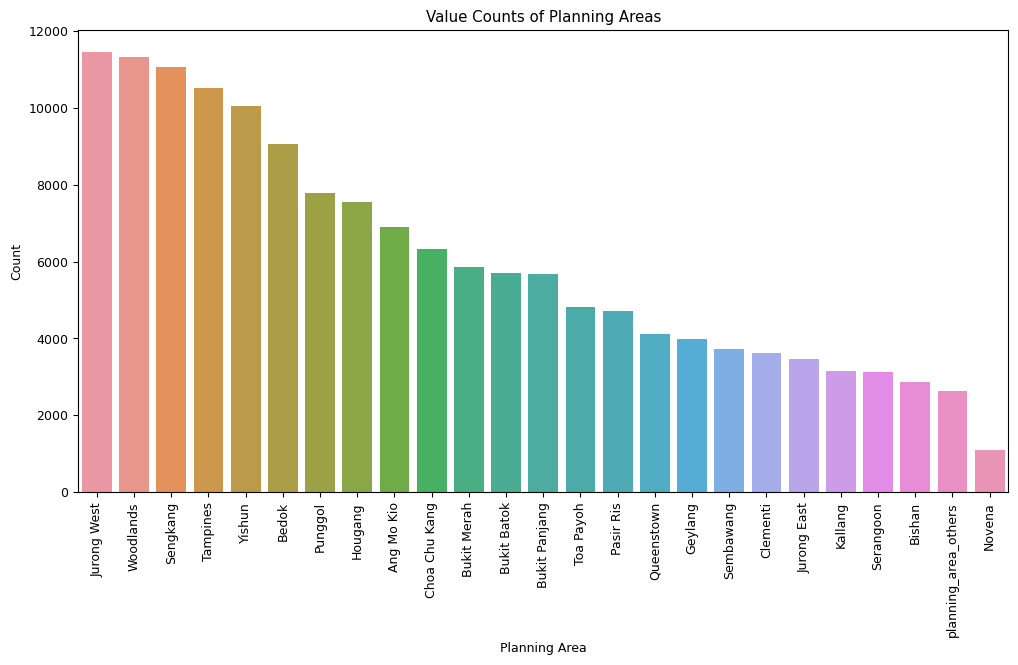

In [47]:
# Calculate the value counts for each unique value in the 'planning_area' column
value_counts = train_cat['planning_area'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Planning Area')
plt.ylabel('Count')
plt.title('Value Counts of Planning Areas')
plt.xticks(rotation=90)
plt.show()

---
#### Flat_model, flat_type, full_flat_type - comparisen

Flat_model, flat_type, and full_flat_type could have some multicollinear information. 
Explore and check the unique values

In [48]:
train_cat.head(10)

,town,flat_type,block,street_name,storey_range,flat_model,full_flat_type,address,postal,planning_area,mrt_name,bus_stop_name,pri_sch_name,sec_sch_name,resale_price
0,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,Model A,4 ROOM Model A,"3B, UPP BOON KENG RD",382003,Kallang,Kallang,Blk 3B,Geylang Methodist School,Geylang Methodist School,680000.00
1,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,Improved,5 ROOM Improved,"153, BISHAN ST 13",570153,Bishan,Bishan,BLK 151A MKT,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,665000.00
2,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,Apartment,EXECUTIVE Apartment,"289B, BT BATOK ST 25",651289,Bukit Batok,Bukit Batok,Blk 289E,Keming Primary School,Yusof Ishak Secondary School,838000.00
3,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,Model A,4 ROOM Model A,"232, BISHAN ST 22",570232,Bishan,Bishan,Opp Bishan Nth Shop Mall,Catholic High School,Catholic High School,550000.00
4,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,Simplified,4 ROOM Simplified,"876, YISHUN ST 81",760876,Yishun,Khatib,Blk 873,Naval Base Primary School,Orchid Park Secondary School,298000.00
5,GEYLANG,3 ROOM,95,ALJUNIED CRES,07 TO 09,Improved,3 ROOM Improved,"95, ALJUNIED CRES",380095,Geylang,MacPherson,Blk 90,Saint Margaret's Primary School,Geylang Methodist School,335000.00
6,HOUGANG,5 ROOM,641,HOUGANG AVE 8,07 TO 09,Improved,5 ROOM Improved,"641, HOUGANG AVE 8",530641,Hougang,Kovan,Blk 639,Xinmin Primary School,Bowen Secondary School,433000.00
7,BEDOK,3 ROOM,701,BEDOK RESERVOIR RD,06 TO 10,New Generation,3 ROOM New Generation,"701, BEDOK RESERVOIR RD",470701,Bedok,Bedok North,Opp Blk 701,Damai Primary School,Damai Secondary School,340000.00
8,BISHAN,5 ROOM,450,SIN MING AVE,10 TO 12,Improved,5 ROOM Improved,"450, SIN MING AVE",570450,Bishan,Marymount,Blk 454,Ai Tong School,Peirce Secondary School,700000.00
9,SENGKANG,5 ROOM,307D,ANCHORVALE RD,10 TO 12,Improved,5 ROOM Improved,"307D, ANCHORVALE RD",544307,Sengkang,Sengkang,Blk 309D,Anchor Green Primary School,Nan Chiau High School,490000.00


In [49]:
#view unique values for flat_model and full_flat_type
print(train_cat['flat_model'].unique())
print(train_cat['flat_type'].unique())

['Model A' 'Improved' 'Apartment' 'Simplified' 'New Generation'
 'Premium Apartment' 'Model A2' 'Maisonette' 'Standard' 'DBSS' 'Terrace'
 'Model A-Maisonette' 'Type S1' 'Premium Apartment Loft' 'Adjoined flat'
 'Multi Generation' 'Type S2' 'Premium Maisonette' 'Improved-Maisonette'
 '2-room']
['4 ROOM' '5 ROOM' 'EXECUTIVE' '3 ROOM' '2 ROOM' '1 ROOM'
 'MULTI-GENERATION']


In [50]:
#check value counts
flat_model_count = train_cat['flat_model'].value_counts()
flat_model_count

Model A                   46261
Improved                  38514
New Generation            23366
Premium Apartment         15091
Simplified                 7239
Apartment                  6080
Standard                   4867
Maisonette                 4364
Model A2                   2064
DBSS                       1658
Model A-Maisonette          262
Adjoined flat               260
Type S1                     242
Type S2                     127
Terrace                      95
Multi Generation             56
Premium Apartment Loft       50
Improved-Maisonette          19
Premium Maisonette           15
2-room                        4
Name: flat_model, dtype: int64

In [51]:
#check value counts
flat_type_count = train_cat['flat_type'].value_counts()
flat_type_count

4 ROOM              61136
3 ROOM              39060
5 ROOM              36415
EXECUTIVE           11989
2 ROOM               1896
1 ROOM                 82
MULTI-GENERATION       56
Name: flat_type, dtype: int64

---
Plotting bar chart:

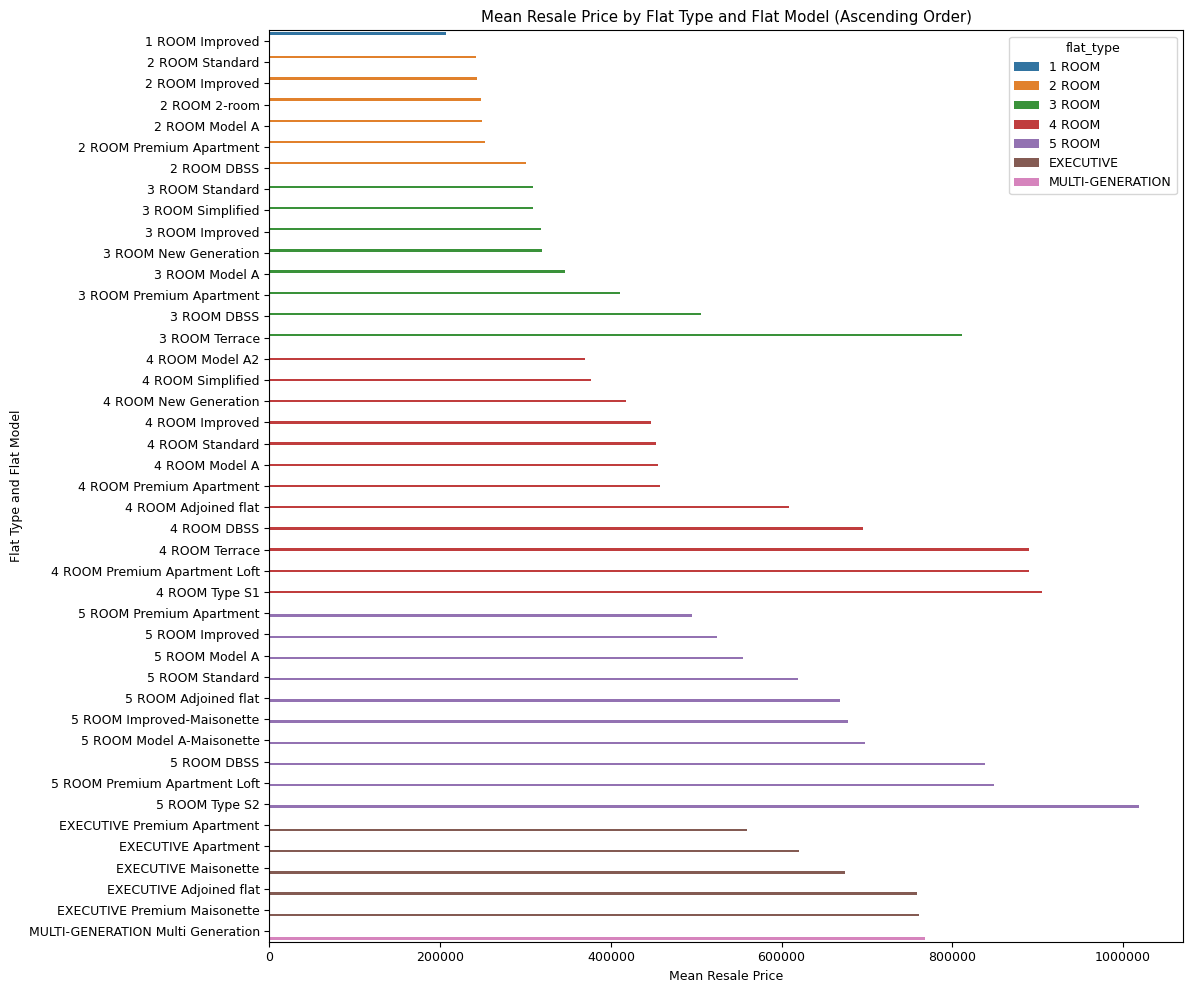

In [188]:
# Calculate the mean resale_price for each unique full flat type and flat type
mean_prices = train_cat.groupby(['flat_type', 'full_flat_type'])['resale_price'].mean().reset_index()

# Sort the DataFrame based on mean resale_price in ascending order within each flat type
mean_prices_sorted = mean_prices.sort_values(by=['flat_type', 'resale_price'])

# Create a bar chart using seaborn
plt.figure(figsize=(12, 10))
sns.barplot(data=mean_prices_sorted, x='resale_price', y='full_flat_type', hue='flat_type', alpha=1)

# Set labels and title
plt.xlabel('Mean Resale Price')
plt.ylabel('Flat Type and Flat Model')
plt.title('Mean Resale Price by Flat Type and Flat Model (Ascending Order)')
plt.ticklabel_format(axis='x', style='plain')

# Show the plot
plt.tight_layout()
plt.show()

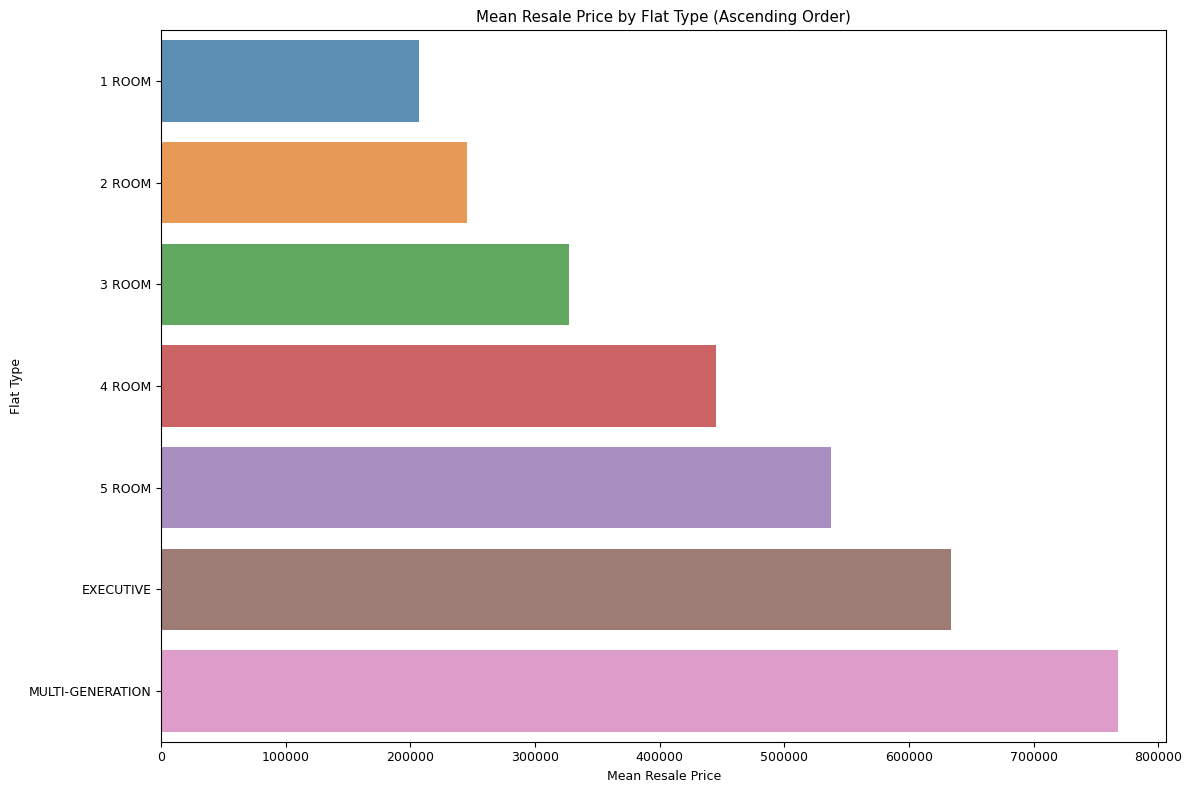

In [53]:
# Calculate the mean resale_price for each unique flat_type
mean_prices_by_flat_type = train_cat.groupby('flat_type')['resale_price'].mean().reset_index()

# Sort the DataFrame based on mean resale_price in ascending order
mean_prices_by_flat_type_sorted = mean_prices_by_flat_type.sort_values(by='resale_price', ascending=True)

# Create a bar chart using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=mean_prices_by_flat_type_sorted, x='resale_price', y='flat_type', alpha=0.8)

# Set labels and title
plt.xlabel('Mean Resale Price')
plt.ylabel('Flat Type')
plt.title('Mean Resale Price by Flat Type (Ascending Order)')

# Show the plot
plt.tight_layout()
plt.show()

**Findings:**<br>
When plotting flat type against mean resale price, we see a trend which is expected - the larger (i.e. more rooms) the flat is, the higher the resale price. However, what is interesting is when we look at the first chart plotting both flat type and flat model, there are actually smaller flats of special models which could outperform larger flats in terms of resale price.<br>

---
#### Check value counts for categorical features

In [54]:
train_cat.nunique()

town                26
flat_type            7
block             2514
street_name        553
storey_range        25
flat_model          20
full_flat_type      43
address           9157
postal            9125
planning_area       25
mrt_name            94
bus_stop_name     1657
pri_sch_name       177
sec_sch_name       134
resale_price      3295
dtype: int64

I decided to drop block, address, postal, bus_stop_name, as these features had too many unique values, and may cause too much noise to the model.<br>
Resale_price will be dropped because it has been captured in the train_num dataframe.

---
Select several train categorical features to further explore and plot boxplots:

In [55]:
#selected features
train_cat_plot = ['flat_type', 'flat_model', 'full_flat_type', 'planning_area']

Boxplot for selected features vs resale price:

In [56]:
def boxplot(df):
    for i in train_cat_plot:
        plt.figure(figsize=(30, 15))
        sns.boxplot(data=train_cat, x=i, y="resale_price")
        plt.xticks(rotation=90)  # Set the x-axis text to be vertical
        plt.title(f"{i} vs resale_price")
        plt.show()


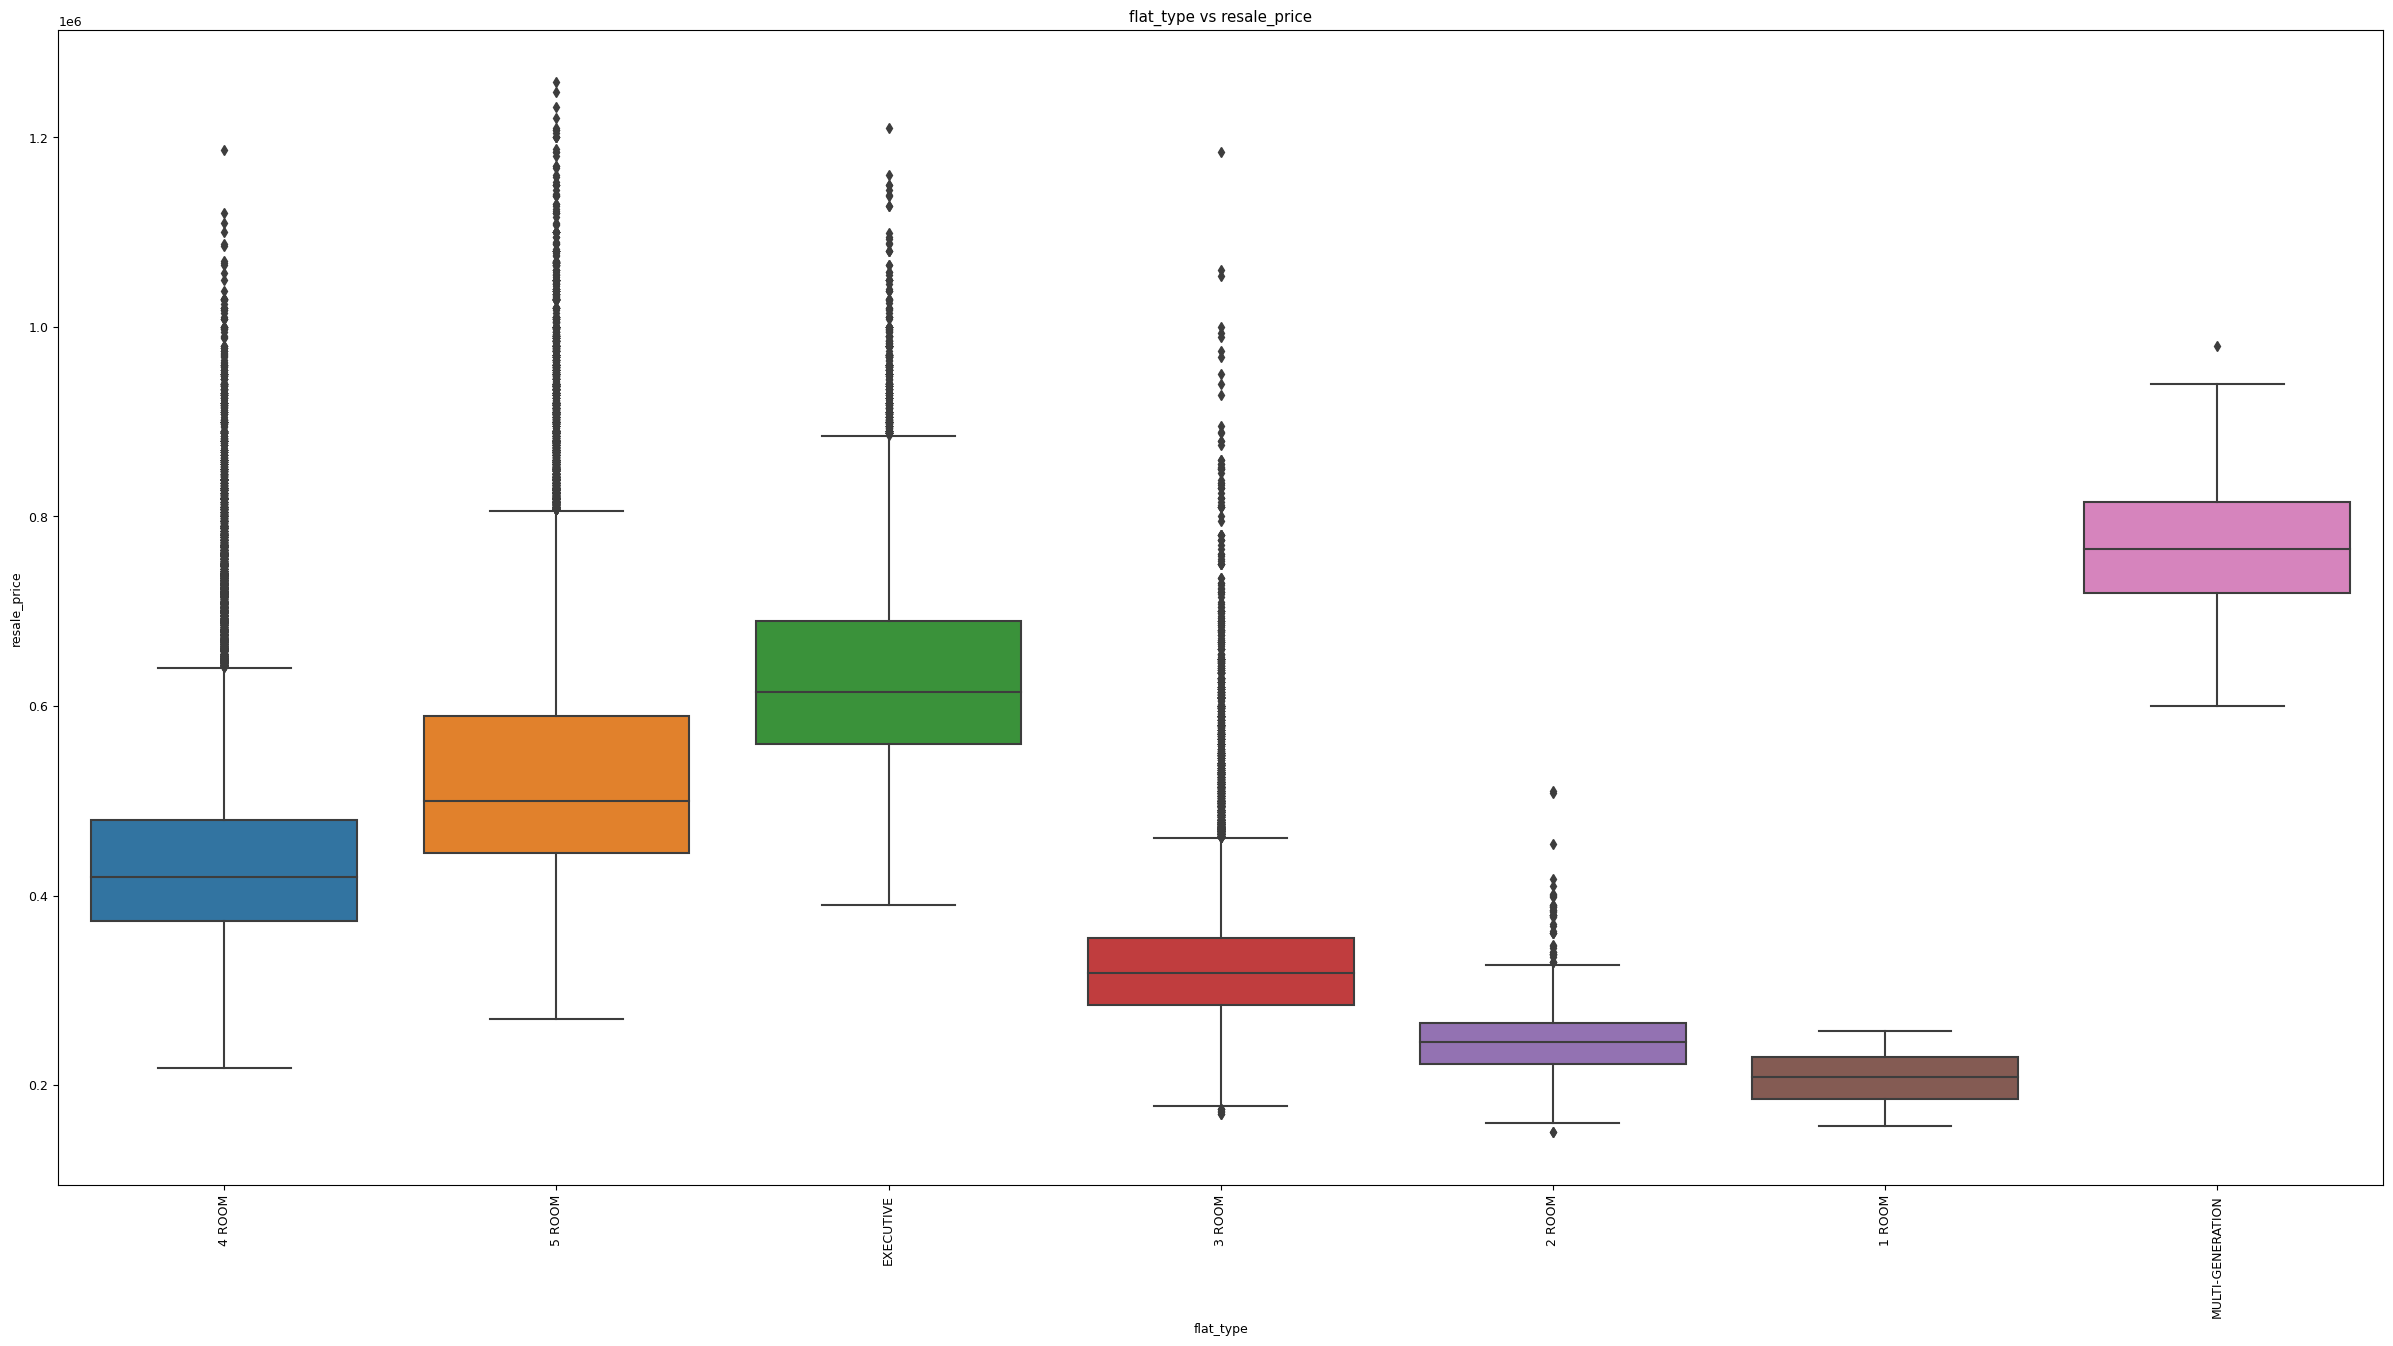

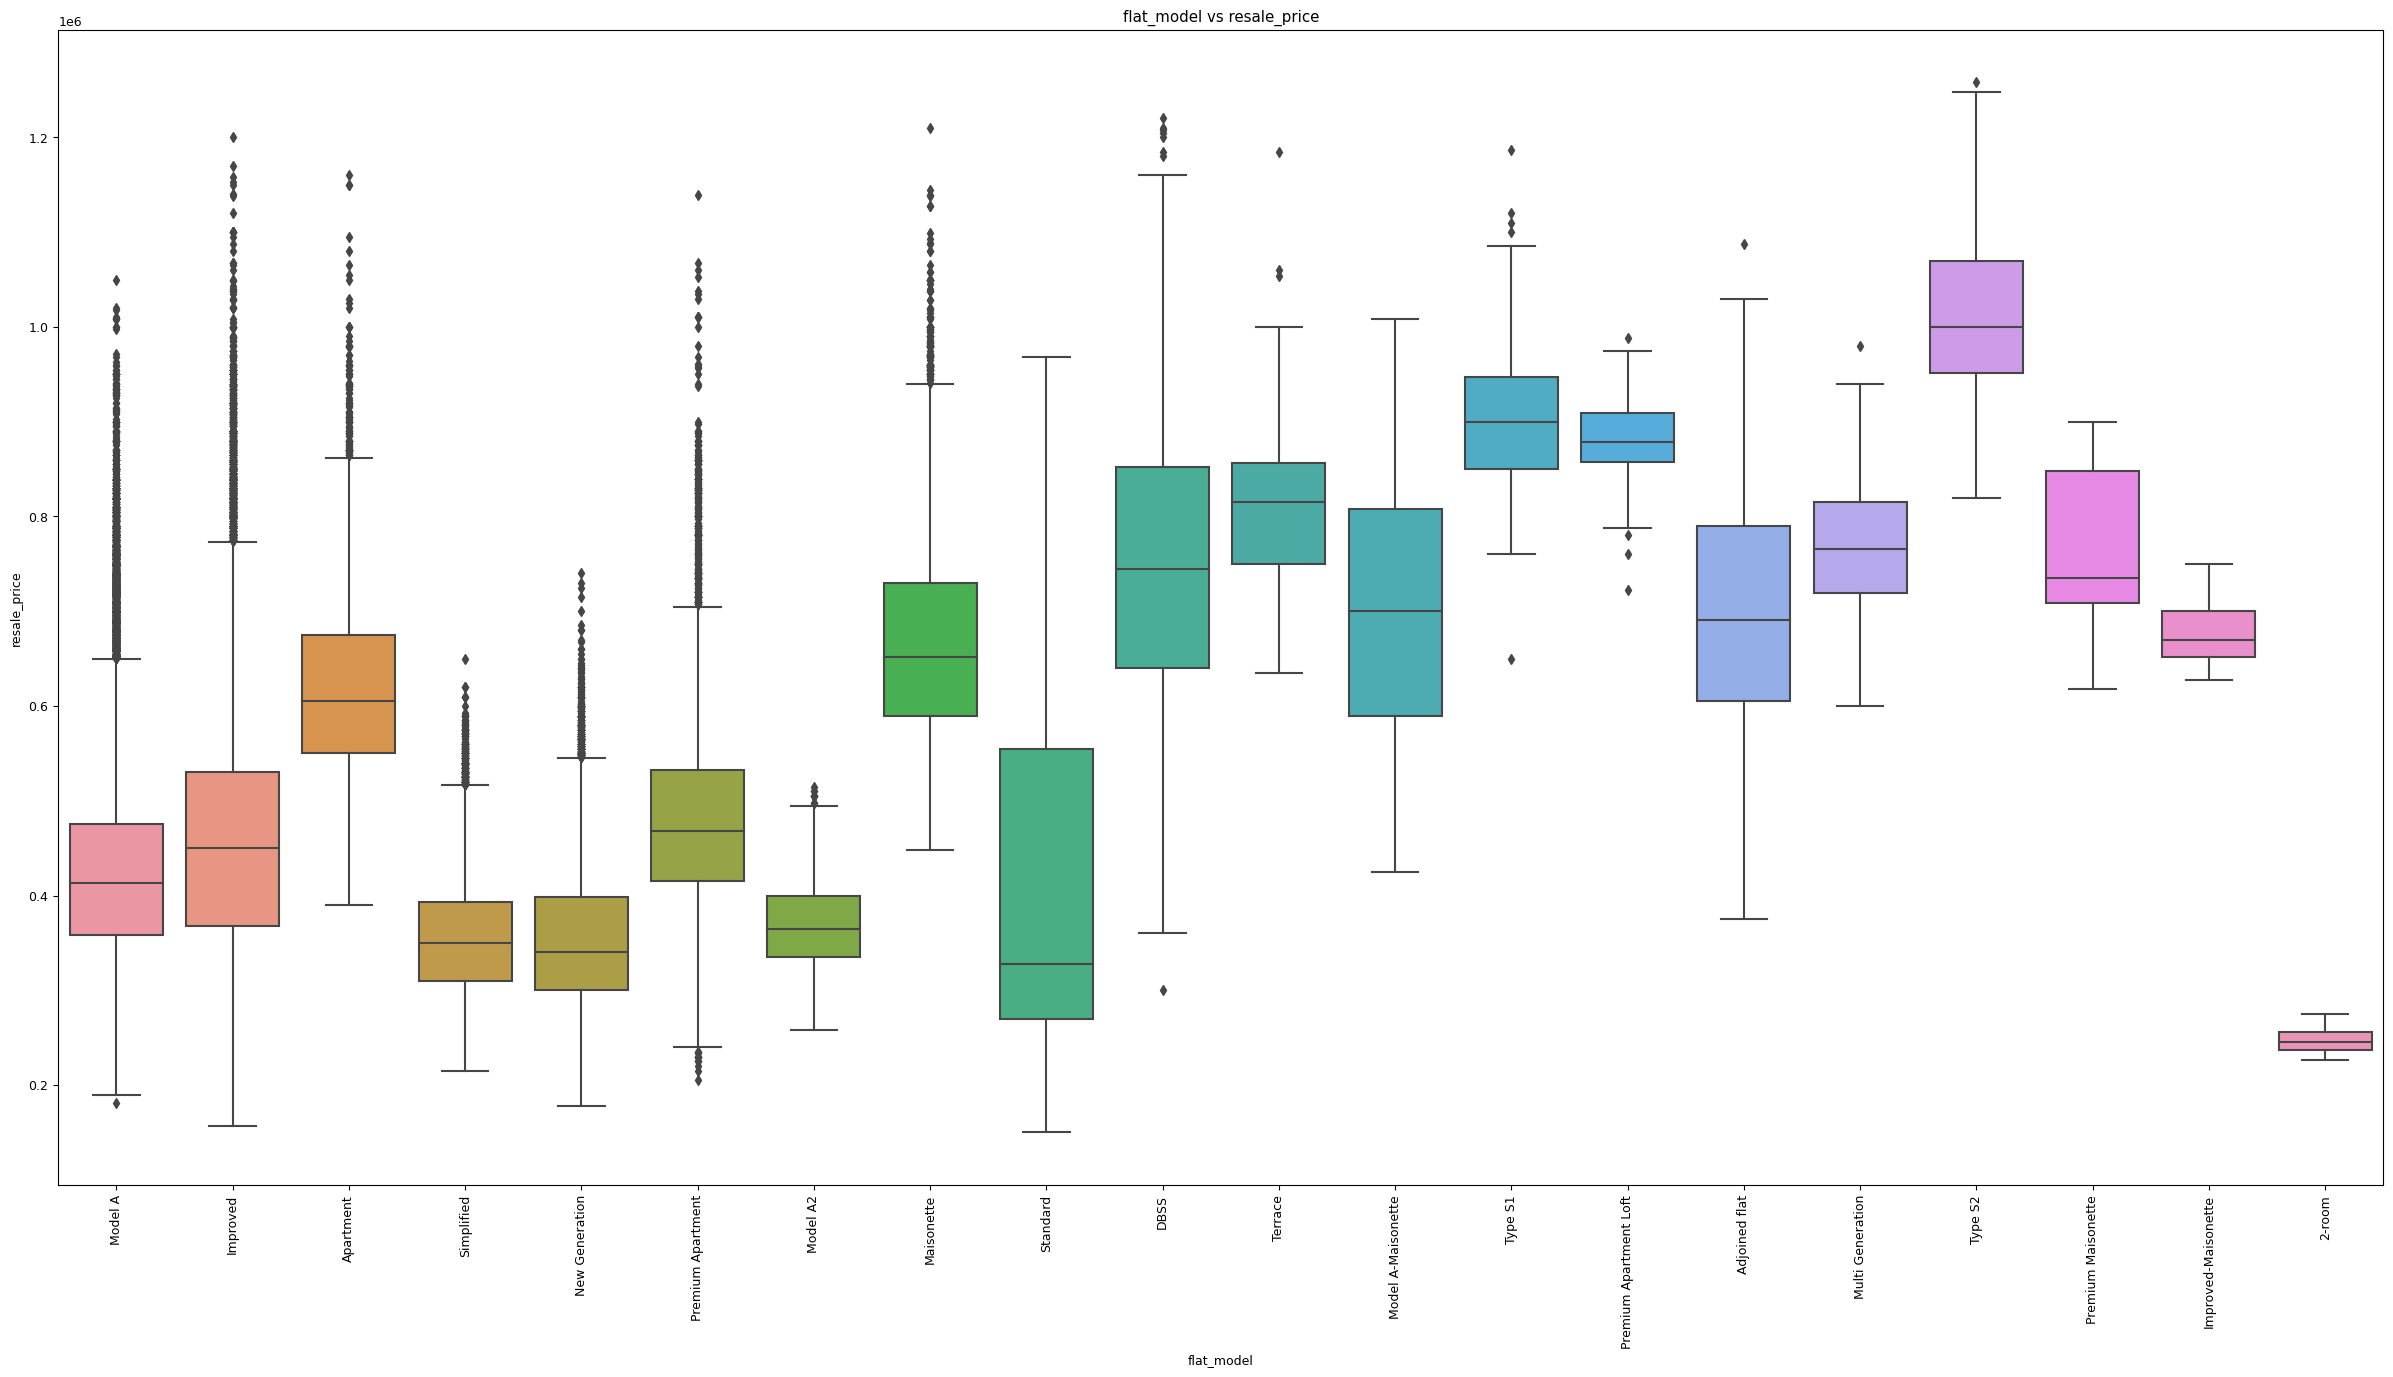

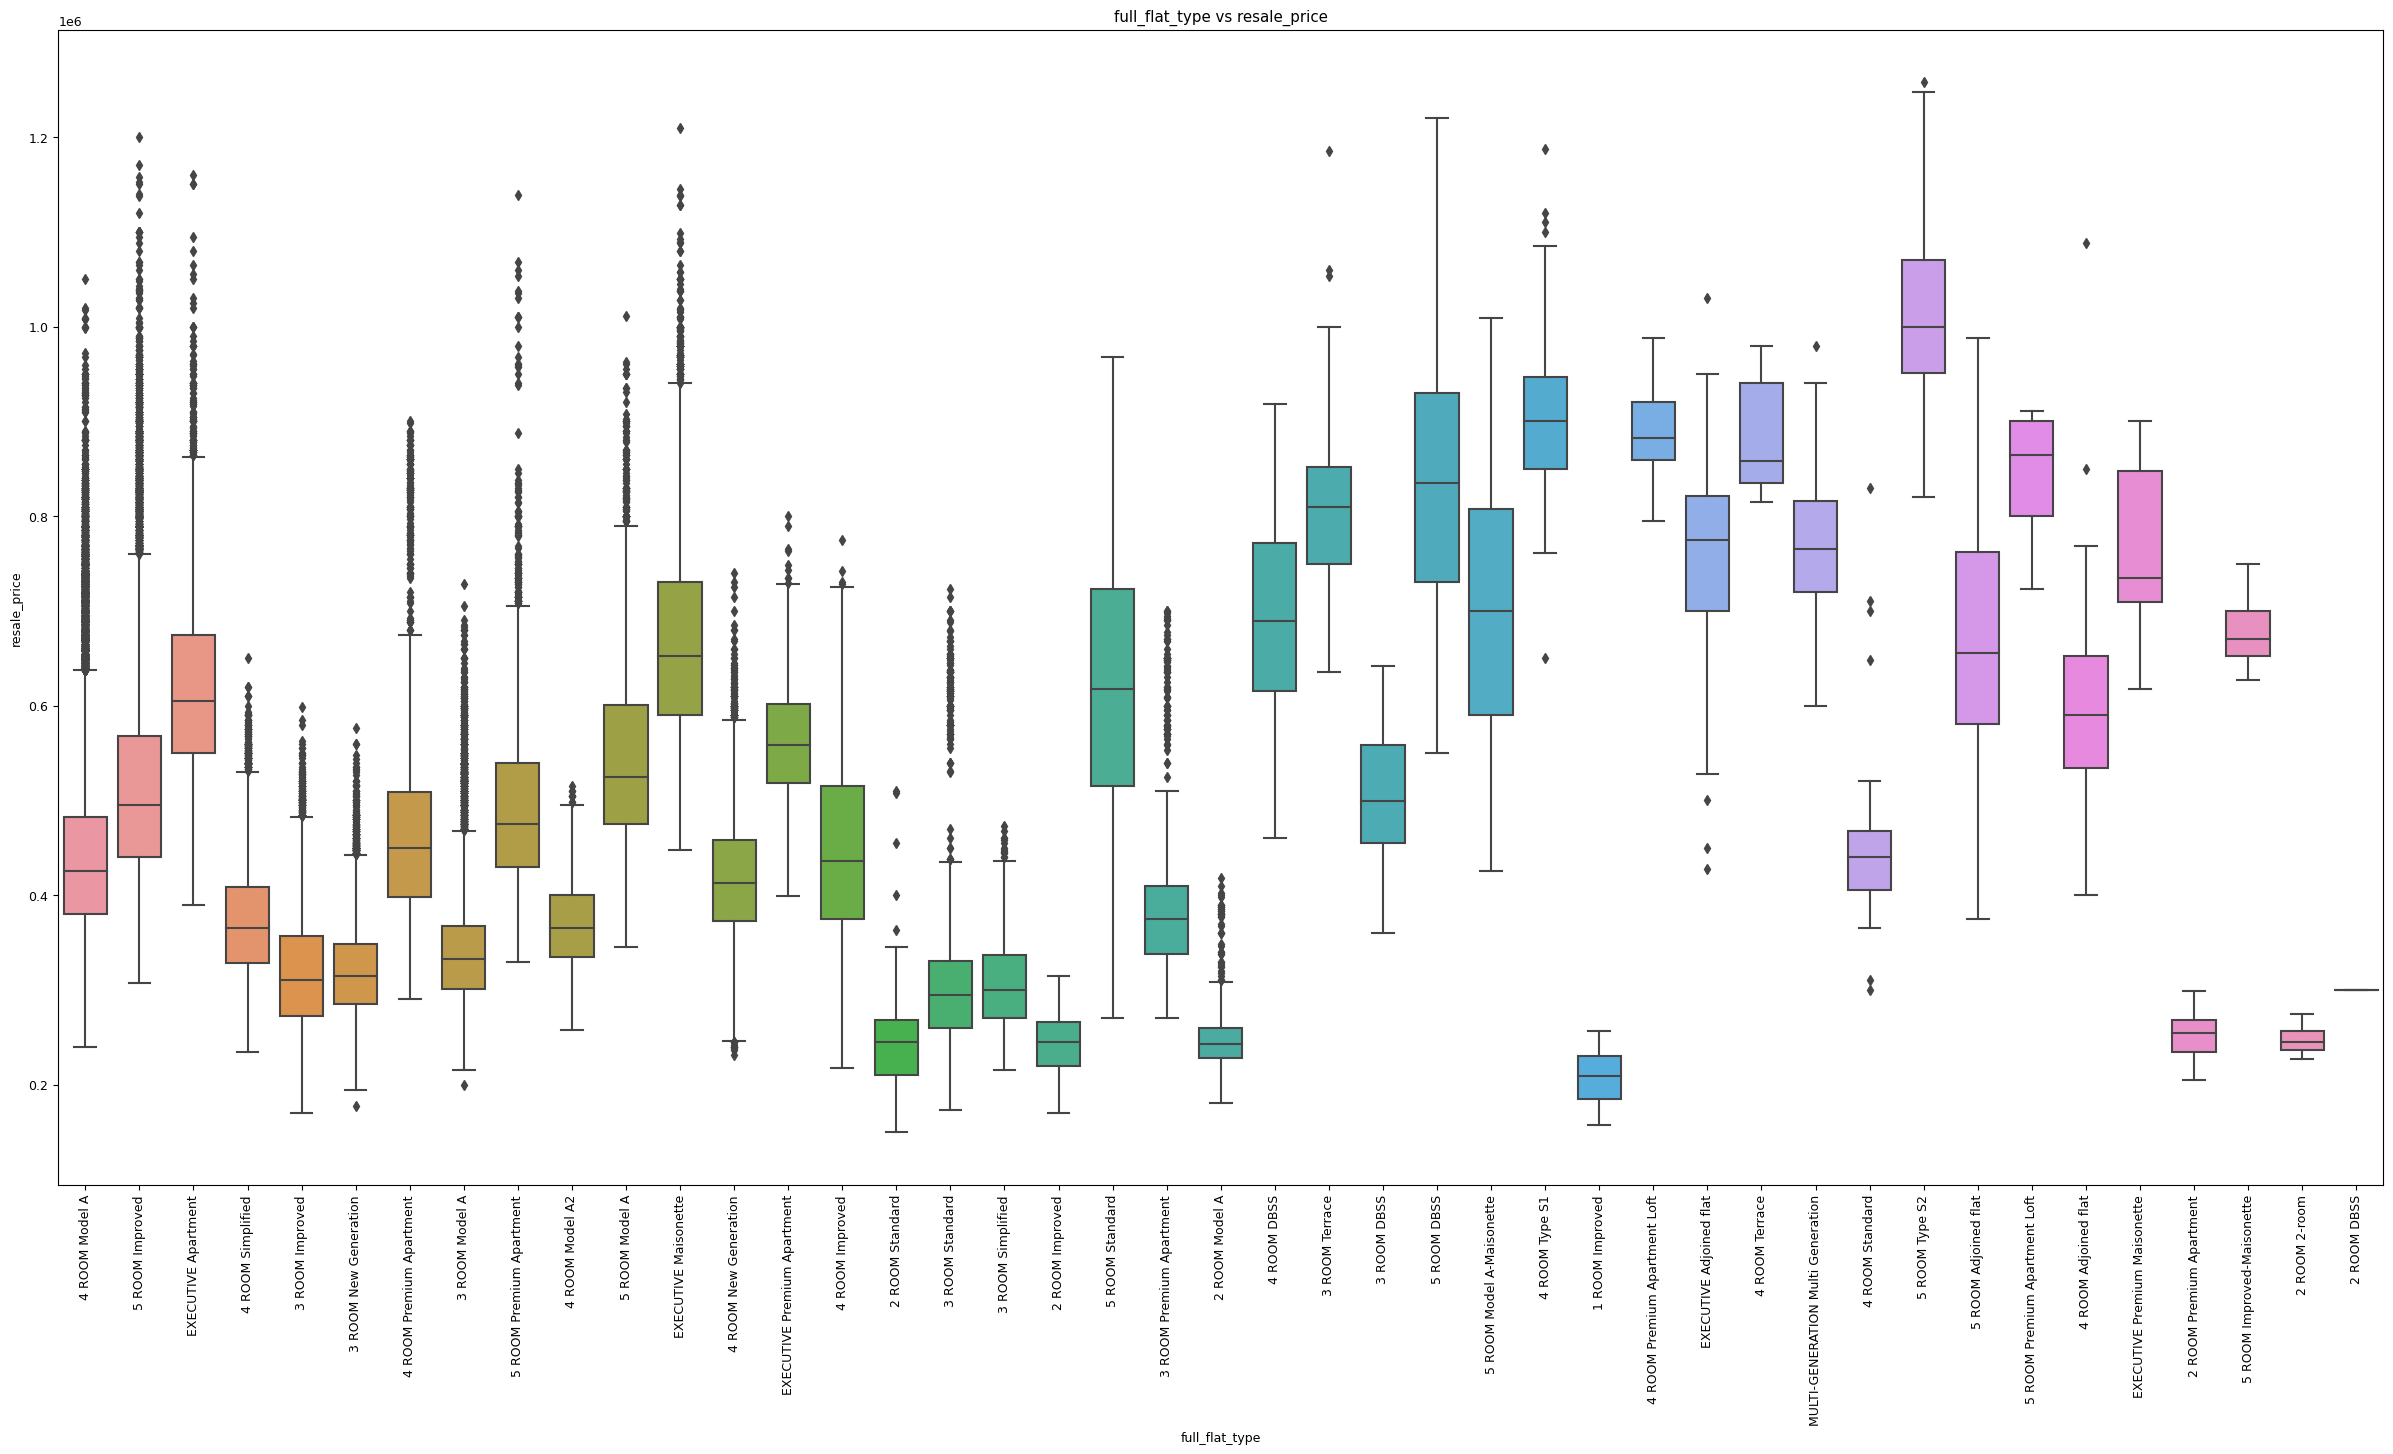

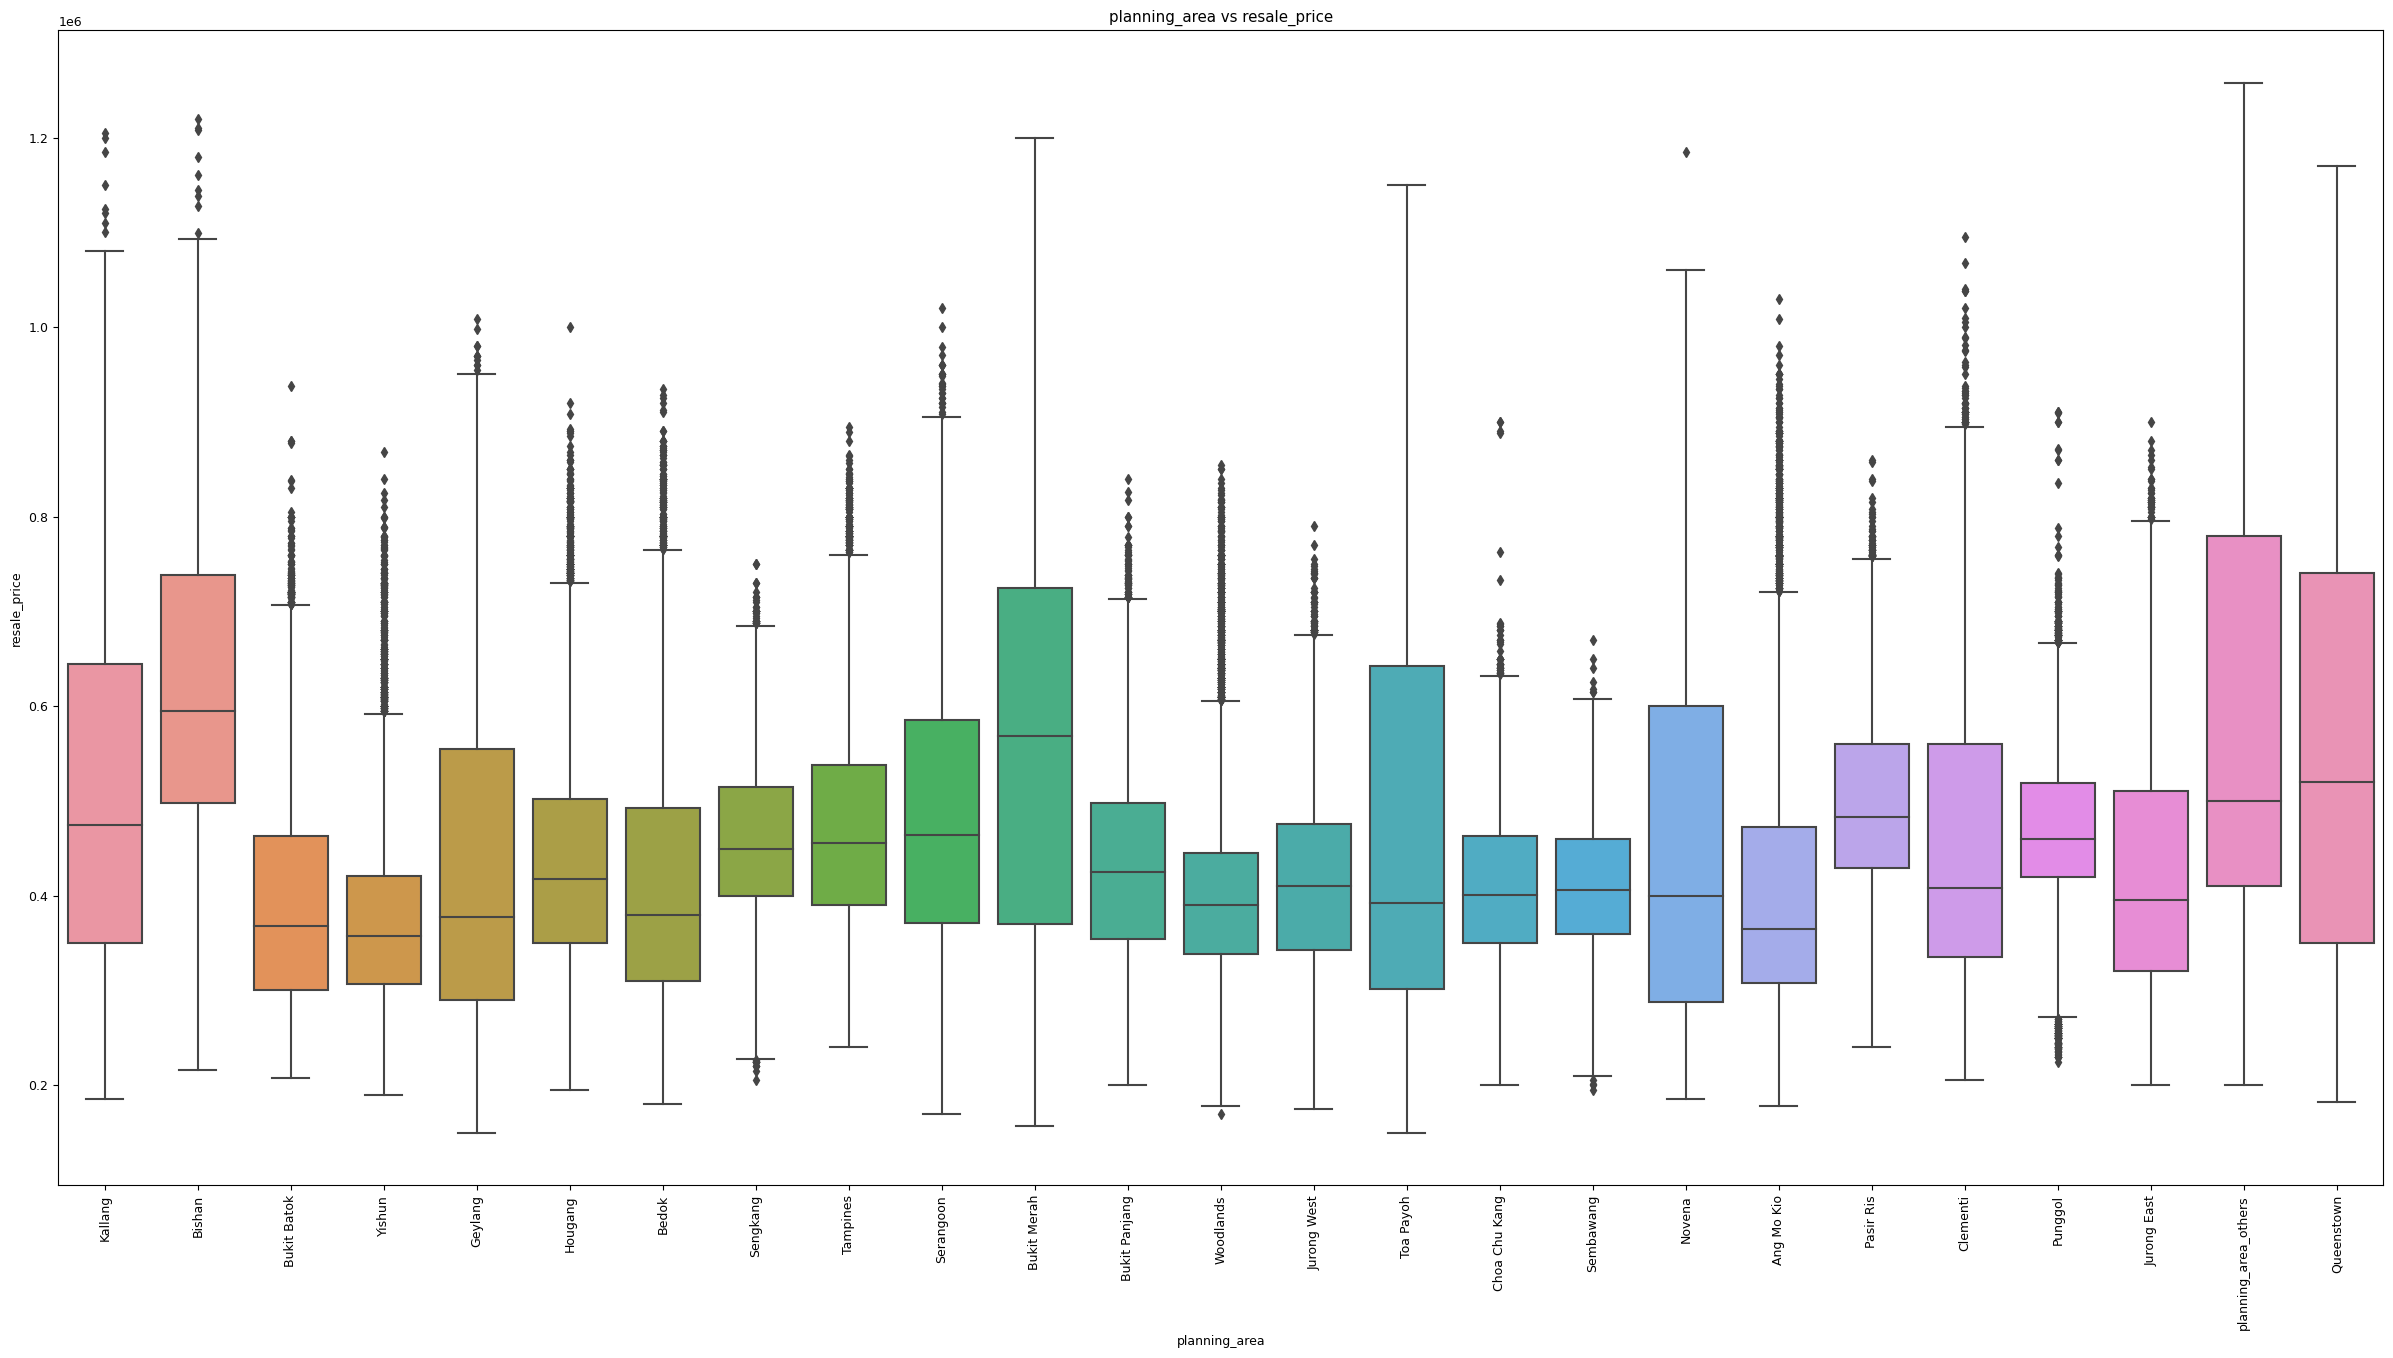

In [57]:
boxplot(train_cat)

**Outliers in categorical features:**
In the above features, we observe quite a large number of outliers. However, due to the significant proportion of outliers, it is decided that we keep the outliers. Also, the outliers appear in all features so dropping outliers from one feature may lead to exponential crucial information loss for all other features.

---
#### Columns (categorical) to be dropped
Drop columns:
* 'storey_range' - as it has been accounted for earlier when we used 'mid_storey' since it gives us the median value of storey_range
* 'block', 'address', 'postal', 'bus_stop_name' - features had too many unique values, and may cause too much noise to the model.
* 'flat_model' and 'flat_type' - as these information is already captured in 'full_flat_type'

In [58]:
#drop columns
train_cat.drop(['storey_range', 'block', 'address', 'postal', 'bus_stop_name', 'flat_model', 'flat_type', 'resale_price'], axis=1, inplace=True)
train_cat.head()

,town,street_name,full_flat_type,planning_area,mrt_name,pri_sch_name,sec_sch_name
0,KALLANG/WHAMPOA,UPP BOON KENG RD,4 ROOM Model A,Kallang,Kallang,Geylang Methodist School,Geylang Methodist School
1,BISHAN,BISHAN ST 13,5 ROOM Improved,Bishan,Bishan,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School
2,BUKIT BATOK,BT BATOK ST 25,EXECUTIVE Apartment,Bukit Batok,Bukit Batok,Keming Primary School,Yusof Ishak Secondary School
3,BISHAN,BISHAN ST 22,4 ROOM Model A,Bishan,Bishan,Catholic High School,Catholic High School
4,YISHUN,YISHUN ST 81,4 ROOM Simplified,Yishun,Khatib,Naval Base Primary School,Orchid Park Secondary School


In [59]:
train_cat.shape

(150634, 7)

In [190]:
train_cat.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'full_flat_type', 'address', 'postal', 'planning_area',
       'mrt_name', 'bus_stop_name', 'pri_sch_name', 'sec_sch_name',
       'resale_price'],
      dtype='object')

---
## 2.3 Establishing Predictor and Target Variables (Round 1 Model)

**Train - Selected**

In [60]:
train_selected = pd.concat([train_num, binarized_train_num, train_cat], axis=1)

In [61]:
print(train_selected.shape)
train_selected.head()

(150634, 43)


,floor_area_sqm,resale_price,tranc_year,tranc_month,mid_storey,hdb_age,max_floor_lvl,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,studio_apartment_sold,2room_rental,mall_nearest_distance,mall_within_2km,hawker_nearest_distance,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,sec_sch_nearest_dist,cutoff_point,commercial,market_hawker,multistorey_carpark,precinct_pavilion,bus_interchange,mrt_interchange,pri_sch_affiliation,affiliation,town,street_name,full_flat_type,planning_area,mrt_name,pri_sch_name,sec_sch_name
0,90.00,680000.00,2016,5,11,15,25,142,0,0,0,96,46,0,0,0,1094.09,7.00,154.75,13.00,84,60,330.08,29.43,1138.63,78,1138.63,224,0,0,0,0,0,0,1,0,KALLANG/WHAMPOA,UPP BOON KENG RD,4 ROOM Model A,Kallang,Kallang,Geylang Methodist School,Geylang Methodist School
1,130.00,665000.00,2012,7,8,34,9,112,0,0,0,56,56,0,0,0,866.94,3.00,640.15,7.00,80,77,903.66,58.21,415.61,45,447.89,232,0,0,0,0,1,1,1,0,BISHAN,BISHAN ST 13,5 ROOM Improved,Bishan,Bishan,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School
2,144.00,838000.00,2013,7,14,24,16,90,0,0,0,0,30,60,0,0,1459.58,4.00,1762.08,1.00,84,95,1334.25,214.75,498.85,39,180.07,188,0,0,0,0,1,0,0,0,BUKIT BATOK,BT BATOK ST 25,EXECUTIVE Apartment,Bukit Batok,Bukit Batok,Keming Primary School,Yusof Ishak Secondary School
3,103.00,550000.00,2012,4,3,29,11,75,0,0,0,68,7,0,0,0,950.18,4.00,726.22,9.00,32,86,907.45,43.40,389.52,20,389.52,253,1,0,0,0,1,1,1,1,BISHAN,BISHAN ST 22,4 ROOM Model A,Bishan,Bishan,Catholic High School,Catholic High School
4,83.00,298000.00,2017,12,2,34,4,48,0,0,0,30,18,0,0,0,729.77,2.00,1540.15,1.00,45,0,412.34,129.42,401.20,74,312.03,208,0,0,0,0,0,0,0,0,YISHUN,YISHUN ST 81,4 ROOM Simplified,Yishun,Khatib,Naval Base Primary School,Orchid Park Secondary School


In [62]:
import os # to work with files/directories
if not os.path.exists('./data/output'): 
    os.makedirs('./data/output') 

# Save the DataFrame to a CSV file
train_selected.to_csv('./data/output/train_sel.csv', index=False)

In [63]:
#Export pre-pickled dataframe
pickle.dump(train_selected, open('./pkl/train_sel.pkl', 'wb'))

---
Note: Continue to notebook_2_2 for further EDA and summary of EDA